# Project 3 : Federated Semantic Segmentation for self-driving cars

This notebook is build for the project demonstration purposes.  

In [1]:
# before starting need to install some additional packages. Run this only if not already installed
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=2e74ca7ac7588b5ce038b6ea5c32c0458e36b26e530c3f4c7705bd6f74a89261
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [2]:
# first step is to mount the google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# changing the current working directory which contains the py scripts,
# the main notebook and data used for training

import os # this library is used to access the systems files
os.chdir('/content/drive/MyDrive/DAAI_Project3/')
print(os.getcwd())


/content/drive/MyDrive/DAAI_Project3


In [4]:
import os

path = '/content/drive/MyDrive/DAAI_Project3/'

if os.access(path, os.R_OK):
    print("You have read access to this file/directory.")
else:
    print("You do not have read access to this file/directory.")

You have read access to this file/directory.


In [5]:
# ipmporting libraries used throught the project implementation
import logging

import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from torch.utils.data import Subset, DataLoader
from torch.utils.data import Dataset

from torch.backends import cudnn

import torchvision
import transform as T
from client import Client 
from mIoU import StreamSegMetrics
from cityscapes import Cityscapes

import matplotlib.pyplot as plt # for visualizing the cityscape data
import model  # the actual BiSeNet V2 model used for the centralized training
from server import Server
from GTA5 import GTA5
import wandb
from student import Student
import FDA_algorithm as FDA
from torchvision.datasets.mnist import string
from torchvision.datasets import VisionDataset

from PIL import Image
from itertools import chain
from tqdm import tqdm


import os
import os.path
import math

import numpy as np
import pandas as pd
from torch import from_numpy


Step 1: Partition Cityscapes into train and test 
---

As per project requirements, the cityscape data set is partitioned into A and B partitions. 

In [6]:
# creating directories for images/labels folders and text files 
img_dir = '/content/drive/MyDrive/DAAI_Project3/data/Cityscapes/images/'
mask_dir = '/content/drive/MyDrive/DAAI_Project3/data/Cityscapes/labels/'

train_txt = './data/Cityscapes/train.txt'
test_txt = './data/Cityscapes/val.txt'

In [7]:
# this section consists of functions to retrieve the images and labels according
# to the project requirements

# Partition A :
# test data consists of 2 random images from each city
# train data consists of remaining images

def partition_A(img_dir, train=True): # this function takes the folder which consists of images and labels
# and boolean variable to retrieve either images/labels for training or for testing

    img_files = os.listdir(img_dir) # getting a list of all the files in the specified directory

    img_dict_test = {} # creating an empty dictionary for retrieving the test image files names 

    for name in img_files:
        city_name = name.split('_')[0] # retrieving only the name of the city 

        if city_name not in img_dict_test.keys():
            img_dict_test[city_name] = [name] # adding the city name to the dictionary if it doesnt already existis
        elif city_name in img_dict_test.keys() and len(img_dict_test[city_name])<2:
            img_dict_test[city_name].append(name) # adding file with the city name until it is equal to 2 the number
            # of files with the same city name

    # creating the test images/labels lists
    img_test_files = np.array(list(img_dict_test.values())).reshape((1,-1)).tolist()[0]
    img_train_files = img_files
    for file_ in img_test_files:
      if file_ in img_train_files:

        img_train_files.remove(file_)

    if train: # if train is true, it will return train images/labels files
        return img_train_files
    else: # else it will return the test images/labels files 
        return img_test_files

# Partition B
# train data according to the train.txt file
# test data according to the val.txt file
def partition_B(txt_file): # this function takes the text files 

    with open(txt_file, 'r') as t: # reading the files and storing it in a list
        image_files = t.readlines()

    for name in image_files:
        name1 = image_files[image_files.index(name)].replace('\n','') 
        name2 = name1.split('/')[1] 
        image_files[image_files.index(name)] = name2
    
    return image_files

In [ ]:
# to visualize the length of dataset in different partitions
print(f'Training dataset for Partition A: ',len(partition_A(img_dir, train = True)))
print(f'Testing dataset for Partition A: ',len(partition_A(img_dir, train = False)))

print(f'Training dataset for Partition B: ',len(partition_B(train_txt)))
print(f'Testing dataset for Partition B: ',len(partition_B(test_txt)))

Training dataset for Partition A:  708
Testing dataset for Partition A:  42
Training dataset for Partition B:  500
Testing dataset for Partition B:  250


In [8]:
# hyperparameters...to be tuned or optimized....
batch_size = 4     
learn_rate = 0.05  
momentum = 0.9    # Hyperparameter for SGD, keep this at 0.9 when using SGD
num_epochs = 25   # Total number of training epochs (iterations over dataset)
step_size = 8   # How many epochs before decreasing learning rate (if using a step-down policy)
gamma = 0.1   # Multiplicative factor for learning rate step-down
weight_decay = 2e-4
log_freq = 10
n_classes = 19 # total number of classes in cityscapes that are common with GTA data
# image size 
original_imsize = (2048,1024) # width x height
image_size = (1024,512) # original images to be reduced to this size using transforms

hyperparam = {"LR": learn_rate,
         "MOMENTUM": momentum,
         "WEIGHT_DECAY": weight_decay,
         "STEP_SIZE": step_size,
         "GAMMA": gamma
         }

In [9]:
# Defining transforms to be applied on training and testing images/labels
train_transform = T.Compose([T.RandomCrop((512,1024)),
                                      T.ToTensor(),
                                      T.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = T.Compose([T.ToTensor(),
                                      T.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])


In [10]:
# defining datasets and dataloaders for partition A and B

# using function created in the previous section to retrieve the list of image/labels for training and testing
train_data_A = partition_A(img_dir, train = True) # this will return the list with training images file name
test_data_A = partition_A(img_dir, train = False) # this will return the list with testing images file name
train_data_B = partition_B(train_txt) # this will return the list with training images file name
test_data_B = partition_B(test_txt) # this will return the list with testing images file name

# defining dataset for training and testing 

train_dataset_A = Cityscapes(img_dir,mask_dir,train_data_A,transform = train_transform, cl19 = True)
test_dataset_A = Cityscapes(img_dir,mask_dir,test_data_A,transform = test_transform, cl19 = True)

train_dataset_B = Cityscapes(img_dir,mask_dir,train_data_B,transform = train_transform, cl19 = True)
test_dataset_B = Cityscapes(img_dir,mask_dir,test_data_B,transform = test_transform, cl19 = True)

# defining dataloaders  

train_dataloader_A = DataLoader(train_dataset_A, batch_size = batch_size, shuffle = True )
test_dataloader_A = DataLoader(test_dataset_A, batch_size = batch_size, shuffle = False )

train_dataloader_B = DataLoader(train_dataset_B, batch_size = batch_size, shuffle = True )
test_dataloader_B = DataLoader(test_dataset_B, batch_size = batch_size, shuffle = False )

In [ ]:
img, labels = train_dataset_A[212]

train_dataset_A.labels[0]

'munster_000123_000019_gtFine_labelIds.png'

torch.Size([512, 1024, 3]) 
 torch.Size([512, 1024])


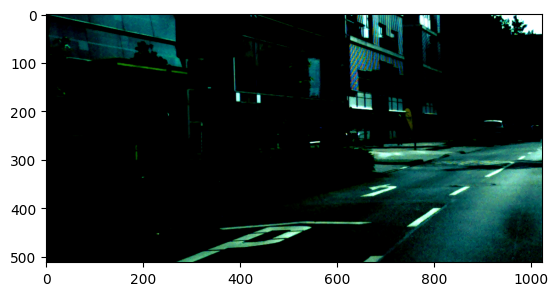

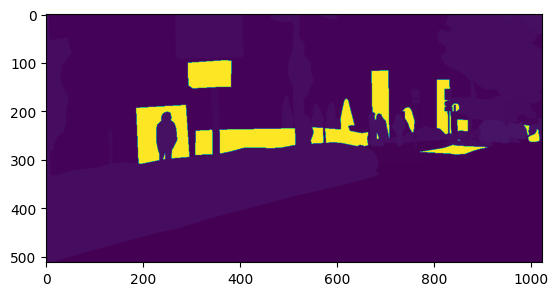

In [ ]:
img, label = (train_dataset_A[212]) # loading first image and label from the train partition A

print(img.permute(1,2,0).shape,'\n',label.shape)
plt.imshow(img.permute(1,2,0)) # the permute function is to change the order of the dimension

plt.show()
plt.imshow(label)
plt.show()


# Step 2: Centralized baseline

This section deals with the implementation of BiSeNet V2. The model is trained on both the partitions A & B to fine tune the hyper parameters and transform variables.   

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.empty_cache()


cpu


In [16]:
#defining the wandb config for storing the results and parameters using wandb package
config = {"learning_rate": learn_rate,
          "batch_size": batch_size,
          "momentum": momentum,
          "weight_decay": weight_decay,
          "epochs": num_epochs,
          "step_size": step_size,
          "gamma": gamma,
          "number_classes": n_classes    
}


In [ ]:
# defining model and setting the parameters for training the model
net = model.BiSeNetV2(19) # the model takes input and out channel as its argument......

loss_fn = nn.CrossEntropyLoss(ignore_index = 255)
optimizer = optim.SGD(net.parameters(), lr=learn_rate, momentum=momentum)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

net = net.to(device) # this will bring the network to GPU if DEVICE is cuda
current_step = 0


In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
def update_acc(outputs, labels, number_classes):
    #mIoU accuracy calculation - from FedDrive repository (function update_metrics)
    x, prediction = outputs.max(dim=1) # retrieving the predicted label
    labels = labels.cpu().numpy()
    prediction = prediction.cpu().numpy()
    miou = StreamSegMetrics(n_classes=number_classes)
    miou.update(labels,prediction)
    mIoU_accuracy = miou.get_results()["Mean IoU"]
    miou.reset()

    return mIoU_accuracy

In [ ]:
wandb.init(project="training_datasetA", config = config)
avgIoU = []
for epoch in range(num_epochs):

    print('The current epoch is: ', epoch)

    # Iterate over the dataset
    for images, labels in train_dataloader_A:

      images = images.to(device, dtype = torch.float32)
      labels = labels.to(device, dtype = torch.long)
      net.train() # Sets module in training mode
      optimizer.zero_grad() # Zero-ing the gradients
      pred,_,_,_,_ = net(images)

      #aux_loss=0

      #p_loss = loss_fn(pred[0], labels) # Compute loss based on output and ground truth
      #aux_loss += loss_fn(pred[1],labels)
      #aux_loss += loss_fn(pred[2],labels)
      #aux_loss += loss_fn(pred[3],labels)
      #aux_loss += loss_fn(pred[4],labels)

      #output = pred[0]+pred[1]+pred[2]+pred[3]+pred[4]

      #loss = p_loss + aux_loss
      
      loss = loss_fn(pred, labels)
      mIoU = update_acc(pred, labels, n_classes)
      avgIoU.append(mIoU)

      wandb.log({"loss": loss,
                "mIoU": mIoU})
      
      if current_step % log_freq == 0:
        print('Step {}, Loss {}'.format(current_step, loss.item()))

      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients
      current_step += 1

    # Step the scheduler
    scheduler.step()

wandb.finish()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


The current epoch is:  0
Step 0, Loss 3.3944311141967773
Step 10, Loss 3.084613561630249
Step 20, Loss 2.552598476409912
Step 30, Loss 2.1768460273742676
Step 40, Loss 1.9080562591552734
Step 50, Loss 2.2990846633911133
Step 60, Loss 1.43843412399292
Step 70, Loss 1.5233354568481445
Step 80, Loss 1.547805905342102
Step 90, Loss 1.9773218631744385
Step 100, Loss 1.3513072729110718
Step 110, Loss 1.6117761135101318
The current epoch is:  1
Step 120, Loss 1.3685635328292847
Step 130, Loss 1.5994482040405273
Step 140, Loss 1.3340312242507935
Step 150, Loss 1.1852697134017944
Step 160, Loss 1.1784051656723022
Step 170, Loss 1.2339141368865967
Step 180, Loss 1.849177360534668
Step 190, Loss 1.2143397331237793
Step 200, Loss 1.3038396835327148
Step 210, Loss 1.15688955783844
Step 220, Loss 1.0120116472244263
Step 230, Loss 1.2931619882583618
The current epoch is:  2
Step 240, Loss 1.1240487098693848
Step 250, Loss 1.210968017578125
Step 260, Loss 1.0720888376235962
Step 270, Loss 1.0814093351

loss,█▄▄▅▇▄▂▃▃▃▃▄▂▁▄▃▂▃▂▃▃▂▂▁▃▃▃▅▄▄▃▂▄▂▃▃▃▇▂▃
mIoU,▁▄▄▂▃▄▆▃▅▅▆▄▇█▄▇▆▅▇▆▇▅▆▆▄▆▄▃▅▅▅▆▄▅▇▆▅▄▆▅
loss,0.67891
mIoU,0.26757


In [ ]:
# saving the trained model.
checkpoint = {
          "epoch": epoch,
          "model_state_dict": net.state_dict(),
          "optimizer_state_dict": optimizer.state_dict(),
          "scheduler_state_dict": scheduler.state_dict()
        }
save_path = 'bisenetv2_datasetA_4.pth' # name,(change it every time.)
torch.save(checkpoint, save_path)        

In [ ]:
# testing the trained model with dataset A or B. 

load_path = "bisenetv2_datasetA_4.pth" # mention the saved file name 

torch.cuda.empty_cache()
test_net = model.BiSeNetV2(n_classes)
test_net.to(device)

test_client = Client(f"test_B",test_dataset_A, test_net, batch_size, device, num_epochs, hyperparam, n_classes)
test_client.load_model(load_path)

mIoU_acc = test_client.test()
print(f"Accuracy: {mIoU_acc}")

# Step 3:Federated Semantic Segmentation experiments

This section deals with federated learning. We are using server and clients which are defined in server.py and client.py script for federated learning. 

Also, a uniform and hetergenous splits are defined which are used for training. 

The hyperparameters and transform found in the previous step are used. 

In [18]:
# defining the new paremeters to be used in this section for creating splits and running the fedavg algorithm
n_clients = 40
max_img_per_client = 20

batch_size_fedavg = 2
learn_rate_fedavg = 0.05
momentum_fedavg = 0.9
weight_decay_fedavg = 2e-4

epochs_fedavg = 4
step_size_fedavg = 2
gamma_fedavg  = 0.1
number_rounds = 25

hyperparam_fedavg = {"LR": learn_rate_fedavg,
         "MOMENTUM": momentum_fedavg,
         "WEIGHT_DECAY": weight_decay_fedavg,
         "STEP_SIZE": step_size_fedavg,
         "GAMMA": gamma_fedavg
         }     

In [19]:
# defining the uniform and hetergenous splits for A and B partitions. 

def hetero_split(dataset,n_clients): # this function returns the list of the client based on the n_client defined above, where
# each client has 20 images assigned randomly picked from the training dataset. 

    img_list = dataset.images# this will get all the images in the dataset 
    img_dict = {}
    client_list = []

    for file_ in img_list:
        city = file_.split('_')[0] # getting the city name
        if city not in img_dict.keys():
            img_dict[city] = [] 
        img_dict[city].append(file_) # this will assign the file name to the city
    
    clients_per_city = math.ceil(n_clients/len(img_dict.keys())) 

    for i,city in enumerate(img_dict.keys()):
        x = np.array_split(img_dict[city],clients_per_city) #splits an array into multiple arrays
        y = [list(array) for array in x]
        for j in y:
            client_list.append(j)
        
    for i in range(len(client_list)):
        if len(client_list[i])>max_img_per_client:
            del client_list[i][max_img_per_client:]
        
    if len(client_list)>n_clients:
        client_list = client_list[:n_clients]

    return client_list

def uniform_split(dataset,n_clients): # this function gives the uniform split as described in the step 3 and paper [8].

    img_list = dataset.images # this retrieves all the images in the training dataset 

    img_list = np.array(img_list)
    np.random.shuffle(img_list)
    client_array = np.array_split(img_list,n_clients)
    client_list = [list(array) for array in client_array]

    for i in range(len(client_list)):
        if len(client_list[i])>max_img_per_client:
            del client_list[i][max_img_per_client:]
    
    return client_list

In [20]:
# creating the unifrom(I) and hetero(II) split for partitions A and B.

uniform_split_AI = uniform_split(train_dataset_A,n_clients)
uniform_split_BI = uniform_split(train_dataset_B,n_clients)

hetero_split_AII = hetero_split(train_dataset_A,n_clients)
hetero_split_BII = hetero_split(train_dataset_B,n_clients)

In [ ]:
# run it once for the first time....

#os.mkdir('save')

The uniform split A is used here for trainings of the client. 

In [ ]:

wandb_config_fedavg = {
        "initial_lr": learn_rate_fedavg,
        "step_size": step_size_fedavg,
        "gamma": gamma_fedavg,
        "batch_size": batch_size_fedavg,
        "rounds": number_rounds,
        "dataset": "train_dataset_A",
        "split": 'uniform_split_AI'
        }  
        
path_server = "./save/server_unifrom_AI.pth"
torch.cuda.empty_cache()
net_fedavg = model.BiSeNetV2(n_classes)
net_fedavg.to(device)

clients = [] 
for cl in range(len(uniform_split_AI)):
  client_dataset = Cityscapes(img_dir,mask_dir, uniform_split_AI[cl], transform=train_transform, cl19 = True)
  client = Client(f"c{cl}", client_dataset, net_fedavg, batch_size_fedavg, device, epochs_fedavg, hyperparam_fedavg, autosave=False)
  clients.append(client)

wandb_config_fedavg['split'] = 'unifrom_split_AI' 
wandb.init(project = "FedAvg_SS", config = wandb_config_fedavg)
server = Server(f"{wandb.run.name}_serverA", net_fedavg, device, clients, hyperparam=hyperparam_fedavg, number_classes=n_classes, epochs_per_client=epochs_fedavg)
server.training_fedAvg(clients, rounds=number_rounds, path_server_model=path_server)
wandb.finish()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Running FedAvg training...


Rounds:   0%|          | 0/25 [00:00<?, ?it/s]

ID: c15 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 3.255735397338867, Mean IoU accuracy 0.011269681790505984.



Epoch:  25%|██▌       | 1/4 [00:46<02:18, 46.22s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.166234016418457, Mean IoU accuracy 0.06051715022058926.



Epoch:  50%|█████     | 2/4 [00:50<00:43, 21.54s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.8969030380249023, Mean IoU accuracy 0.030941634605646497.



Epoch:  75%|███████▌  | 3/4 [00:53<00:13, 13.21s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.9988150596618652, Mean IoU accuracy 0.039602311597705726.



Epoch: 100%|██████████| 4/4 [00:57<00:00, 14.28s/it]


Using "run_epoch" function from Client class

ID: c27 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 3.365269422531128, Mean IoU accuracy 0.019911578488736828.



Epoch:  25%|██▌       | 1/4 [00:10<00:31, 10.50s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.466913938522339, Mean IoU accuracy 0.05770173628935401.



Epoch:  50%|█████     | 2/4 [00:13<00:12,  6.33s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7677472829818726, Mean IoU accuracy 0.047095855062587406.



Epoch:  75%|███████▌  | 3/4 [00:17<00:05,  5.02s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8161039352416992, Mean IoU accuracy 0.04606600870692278.



Epoch: 100%|██████████| 4/4 [00:21<00:00,  5.43s/it]


Using "run_epoch" function from Client class

ID: c6 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 3.3980679512023926, Mean IoU accuracy 0.017627477738489827.



Epoch:  25%|██▌       | 1/4 [00:09<00:29,  9.89s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.550835132598877, Mean IoU accuracy 0.03947855856008154.



Epoch:  50%|█████     | 2/4 [00:14<00:13,  6.67s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.0731148719787598, Mean IoU accuracy 0.05355094994603632.



Epoch:  75%|███████▌  | 3/4 [00:17<00:05,  5.22s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.697934865951538, Mean IoU accuracy 0.06435287159858859.



Epoch: 100%|██████████| 4/4 [00:21<00:00,  5.29s/it]


Using "run_epoch" function from Client class

ID: c36 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 3.353452682495117, Mean IoU accuracy 0.016877994507196483.



Epoch:  25%|██▌       | 1/4 [00:09<00:29,  9.75s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5711568593978882, Mean IoU accuracy 0.11797044801853042.



Epoch:  50%|█████     | 2/4 [00:13<00:11,  5.97s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.1908092498779297, Mean IoU accuracy 0.09515076276354292.



Epoch:  75%|███████▌  | 3/4 [00:16<00:04,  4.61s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3089736700057983, Mean IoU accuracy 0.10480681099258009.



Epoch: 100%|██████████| 4/4 [00:19<00:00,  4.88s/it]


Using "run_epoch" function from Client class

ID: c22 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 3.36330246925354, Mean IoU accuracy 0.021180802663941352.



Epoch:  25%|██▌       | 1/4 [00:10<00:32, 10.82s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.733351707458496, Mean IoU accuracy 0.06754291245063.



Epoch:  50%|█████     | 2/4 [00:14<00:13,  6.80s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3912911415100098, Mean IoU accuracy 0.08897841988538197.



Epoch:  75%|███████▌  | 3/4 [00:18<00:05,  5.46s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.290106773376465, Mean IoU accuracy 0.060051883587677185.



Epoch: 100%|██████████| 4/4 [00:22<00:00,  5.51s/it]

Using "run_epoch" function from Client class




Rounds:   4%|▍         | 1/25 [02:22<56:54, 142.25s/it]

ID: c35 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.6823559999465942, Mean IoU accuracy 0.06159721637857861.



Epoch:  25%|██▌       | 1/4 [00:09<00:27,  9.32s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2889716625213623, Mean IoU accuracy 0.09091856774172401.



Epoch:  50%|█████     | 2/4 [00:12<00:11,  5.83s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.943627655506134, Mean IoU accuracy 0.12308120037937667.



Epoch:  75%|███████▌  | 3/4 [00:15<00:04,  4.53s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4829148054122925, Mean IoU accuracy 0.10364453260237352.



Epoch: 100%|██████████| 4/4 [00:18<00:00,  4.71s/it]


Using "run_epoch" function from Client class

ID: c31 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.3974363803863525, Mean IoU accuracy 0.11821649317805617.



Epoch:  25%|██▌       | 1/4 [00:08<00:26,  8.92s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6356643438339233, Mean IoU accuracy 0.0866732745275414.



Epoch:  50%|█████     | 2/4 [00:12<00:11,  5.64s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.03481125831604, Mean IoU accuracy 0.0658311986361247.



Epoch:  75%|███████▌  | 3/4 [00:15<00:04,  4.66s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.061775803565979, Mean IoU accuracy 0.11954253271422245.



Epoch: 100%|██████████| 4/4 [00:19<00:00,  4.82s/it]


Using "run_epoch" function from Client class

ID: c19 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.9683941006660461, Mean IoU accuracy 0.12280424485621683.



Epoch:  25%|██▌       | 1/4 [00:10<00:30, 10.16s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.9027419090270996, Mean IoU accuracy 0.05993120570338561.



Epoch:  50%|█████     | 2/4 [00:14<00:13,  6.56s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4147430658340454, Mean IoU accuracy 0.12166115344542869.



Epoch:  75%|███████▌  | 3/4 [00:17<00:05,  5.10s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6015897989273071, Mean IoU accuracy 0.08914656741489492.



Epoch: 100%|██████████| 4/4 [00:20<00:00,  5.23s/it]


Using "run_epoch" function from Client class

ID: c1 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.7227351665496826, Mean IoU accuracy 0.07427127840380114.



Epoch:  25%|██▌       | 1/4 [00:10<00:30, 10.20s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.360105514526367, Mean IoU accuracy 0.043883607124833.



Epoch:  50%|█████     | 2/4 [00:13<00:12,  6.16s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.9497162103652954, Mean IoU accuracy 0.0537632443427716.



Epoch:  75%|███████▌  | 3/4 [00:17<00:05,  5.03s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.23931884765625, Mean IoU accuracy 0.05627489101297382.



Epoch: 100%|██████████| 4/4 [00:21<00:00,  5.31s/it]


Using "run_epoch" function from Client class

ID: c3 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.2375993728637695, Mean IoU accuracy 0.04207748357282988.



Epoch:  25%|██▌       | 1/4 [00:11<00:33, 11.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6708413362503052, Mean IoU accuracy 0.07950460657153967.



Epoch:  50%|█████     | 2/4 [00:15<00:13,  6.89s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.144370198249817, Mean IoU accuracy 0.1355111595515885.



Epoch:  75%|███████▌  | 3/4 [00:18<00:05,  5.30s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.433303713798523, Mean IoU accuracy 0.09591833361051777.



Epoch: 100%|██████████| 4/4 [00:21<00:00,  5.47s/it]

Using "run_epoch" function from Client class




Rounds:   8%|▊         | 2/25 [04:05<45:38, 119.07s/it]

ID: c9 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.9630647897720337, Mean IoU accuracy 0.08619116410822623.



Epoch:  25%|██▌       | 1/4 [00:10<00:31, 10.53s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5365269184112549, Mean IoU accuracy 0.08401974365401392.



Epoch:  50%|█████     | 2/4 [00:13<00:12,  6.33s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4872920513153076, Mean IoU accuracy 0.09972435810467685.



Epoch:  75%|███████▌  | 3/4 [00:18<00:05,  5.36s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.50735342502594, Mean IoU accuracy 0.12272111970444048.



Epoch: 100%|██████████| 4/4 [00:21<00:00,  5.47s/it]


Using "run_epoch" function from Client class

ID: c39 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.1378860473632812, Mean IoU accuracy 0.07761629935392934.



Epoch:  25%|██▌       | 1/4 [00:10<00:30, 10.08s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.4013924598693848, Mean IoU accuracy 0.025507279014293234.



Epoch:  50%|█████     | 2/4 [00:13<00:12,  6.28s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8800294399261475, Mean IoU accuracy 0.060876844208533974.



Epoch:  75%|███████▌  | 3/4 [00:16<00:04,  4.76s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.4610438346862793, Mean IoU accuracy 0.07456498478181316.



Epoch: 100%|██████████| 4/4 [00:19<00:00,  4.93s/it]


Using "run_epoch" function from Client class

ID: c24 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2309762239456177, Mean IoU accuracy 0.12264735149058217.



Epoch:  25%|██▌       | 1/4 [00:10<00:31, 10.48s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2572274208068848, Mean IoU accuracy 0.13079663035860656.



Epoch:  50%|█████     | 2/4 [00:13<00:12,  6.36s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6439563035964966, Mean IoU accuracy 0.08352095829513181.



Epoch:  75%|███████▌  | 3/4 [00:17<00:05,  5.24s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3333014249801636, Mean IoU accuracy 0.1055204116251419.



Epoch: 100%|██████████| 4/4 [00:21<00:00,  5.45s/it]


Using "run_epoch" function from Client class

ID: c38 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.8043133020401, Mean IoU accuracy 0.08700655211359763.



Epoch:  25%|██▌       | 1/4 [00:08<00:25,  8.60s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.0422916412353516, Mean IoU accuracy 0.04877607908237823.



Epoch:  50%|█████     | 2/4 [00:12<00:12,  6.02s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.234790086746216, Mean IoU accuracy 0.05260733180049011.



Epoch:  75%|███████▌  | 3/4 [00:15<00:04,  4.68s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1408562660217285, Mean IoU accuracy 0.09225181958531085.



Epoch: 100%|██████████| 4/4 [00:18<00:00,  4.73s/it]


Using "run_epoch" function from Client class

ID: c7 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.5593030452728271, Mean IoU accuracy 0.09126678535474596.



Epoch:  25%|██▌       | 1/4 [00:10<00:30, 10.24s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3175992965698242, Mean IoU accuracy 0.18913185046506728.



Epoch:  50%|█████     | 2/4 [00:13<00:12,  6.20s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.847395896911621, Mean IoU accuracy 0.03695537411146252.



Epoch:  75%|███████▌  | 3/4 [00:16<00:04,  4.91s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2527836561203003, Mean IoU accuracy 0.15858912900775626.



Epoch: 100%|██████████| 4/4 [00:21<00:00,  5.28s/it]

Using "run_epoch" function from Client class




Rounds:  12%|█▏        | 3/25 [05:49<41:10, 112.31s/it]

ID: c17 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.7693822383880615, Mean IoU accuracy 0.07438731328197133.



Epoch:  25%|██▌       | 1/4 [00:10<00:30, 10.11s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.2940618991851807, Mean IoU accuracy 0.1036564174688605.



Epoch:  50%|█████     | 2/4 [00:14<00:13,  6.63s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.295239210128784, Mean IoU accuracy 0.05065002712170784.



Epoch:  75%|███████▌  | 3/4 [00:18<00:05,  5.30s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4775687456130981, Mean IoU accuracy 0.10209582632040418.



Epoch: 100%|██████████| 4/4 [00:21<00:00,  5.35s/it]


Using "run_epoch" function from Client class

ID: c15 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.5882033109664917, Mean IoU accuracy 0.08224332187278093.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.39s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2624746561050415, Mean IoU accuracy 0.13022664693033298.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.78s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3925315141677856, Mean IoU accuracy 0.09107856224544962.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.81s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4175121784210205, Mean IoU accuracy 0.11140012727292439.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.67s/it]


Using "run_epoch" function from Client class

ID: c34 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2428579330444336, Mean IoU accuracy 0.15336250952029393.



Epoch:  25%|██▌       | 1/4 [00:09<00:28,  9.48s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2984263896942139, Mean IoU accuracy 0.15587482377540327.



Epoch:  50%|█████     | 2/4 [00:12<00:11,  5.93s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.9821242094039917, Mean IoU accuracy 0.0757334561889176.



Epoch:  75%|███████▌  | 3/4 [00:15<00:04,  4.57s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6320812702178955, Mean IoU accuracy 0.13918809146239813.



Epoch: 100%|██████████| 4/4 [00:19<00:00,  4.76s/it]


Using "run_epoch" function from Client class

ID: c2 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.7593131065368652, Mean IoU accuracy 0.10676076031818904.



Epoch:  25%|██▌       | 1/4 [00:10<00:31, 10.36s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3308011293411255, Mean IoU accuracy 0.07653207823649193.



Epoch:  50%|█████     | 2/4 [00:13<00:12,  6.40s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.0278263092041016, Mean IoU accuracy 0.12455185279366375.



Epoch:  75%|███████▌  | 3/4 [00:18<00:05,  5.37s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3626874685287476, Mean IoU accuracy 0.13303188805076924.



Epoch: 100%|██████████| 4/4 [00:21<00:00,  5.36s/it]


Using "run_epoch" function from Client class

ID: c27 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.4137988090515137, Mean IoU accuracy 0.0907121892152722.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.36s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5261765718460083, Mean IoU accuracy 0.1265878294301507.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.42s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3143230676651, Mean IoU accuracy 0.10019588654727367.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.83s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.6106419563293457, Mean IoU accuracy 0.06229655856505287.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.64s/it]

Using "run_epoch" function from Client class




Rounds:  16%|█▌        | 4/25 [07:21<36:28, 104.22s/it]

ID: c6 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.4558998346328735, Mean IoU accuracy 0.11544655766497153.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.37s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7435271739959717, Mean IoU accuracy 0.09269169950667161.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.44s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4470248222351074, Mean IoU accuracy 0.09072068230511944.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.87s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7948404550552368, Mean IoU accuracy 0.12293474454040014.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.63s/it]


Using "run_epoch" function from Client class

ID: c31 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.8236291408538818, Mean IoU accuracy 0.1295011995964285.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.96s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.207024097442627, Mean IoU accuracy 0.08137120590854116.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.01s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.546973466873169, Mean IoU accuracy 0.14938351740367364.



Epoch:  75%|███████▌  | 3/4 [00:09<00:03,  3.33s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6170456409454346, Mean IoU accuracy 0.15525689487515518.



Epoch: 100%|██████████| 4/4 [00:13<00:00,  3.29s/it]


Using "run_epoch" function from Client class

ID: c36 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.228822112083435, Mean IoU accuracy 0.14556910193697986.



Epoch:  25%|██▌       | 1/4 [00:03<00:09,  3.06s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.973132848739624, Mean IoU accuracy 0.14246616434129403.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.01s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.207165241241455, Mean IoU accuracy 0.14182767696573745.



Epoch:  75%|███████▌  | 3/4 [00:09<00:03,  3.09s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2978395223617554, Mean IoU accuracy 0.12585428887018038.



Epoch: 100%|██████████| 4/4 [00:13<00:00,  3.27s/it]


Using "run_epoch" function from Client class

ID: c19 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.962139368057251, Mean IoU accuracy 0.12300340424548746.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.41s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.442654609680176, Mean IoU accuracy 0.0699578874968327.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.39s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5071606636047363, Mean IoU accuracy 0.07037029875004429.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.43s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6664825677871704, Mean IoU accuracy 0.10509957381528671.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.63s/it]


Using "run_epoch" function from Client class

ID: c7 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.520643711090088, Mean IoU accuracy 0.10696310293895432.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.51s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3955460786819458, Mean IoU accuracy 0.15667070446291917.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.42s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1183996200561523, Mean IoU accuracy 0.18324227246153127.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.40s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6227174997329712, Mean IoU accuracy 0.06023042017765824.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.63s/it]

Using "run_epoch" function from Client class




Rounds:  20%|██        | 5/25 [08:31<30:41, 92.10s/it] 

ID: c24 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.461033821105957, Mean IoU accuracy 0.11593695128983071.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.38s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.536299228668213, Mean IoU accuracy 0.14497999165434178.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.36s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.489699363708496, Mean IoU accuracy 0.12641728746161687.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.38s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1602461338043213, Mean IoU accuracy 0.10675451433246094.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.59s/it]


Using "run_epoch" function from Client class

ID: c19 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.052241802215576, Mean IoU accuracy 0.06373711294745366.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.55s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.216703414916992, Mean IoU accuracy 0.10833892138837718.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.41s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3197410106658936, Mean IoU accuracy 0.08424381952743316.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.37s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6292636394500732, Mean IoU accuracy 0.1074532967457779.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.60s/it]


Using "run_epoch" function from Client class

ID: c1 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.1580910682678223, Mean IoU accuracy 0.1558216794719874.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.63s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4554637670516968, Mean IoU accuracy 0.16256630002918743.



Epoch:  50%|█████     | 2/4 [00:07<00:06,  3.49s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4668400287628174, Mean IoU accuracy 0.10107741914435626.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.44s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.9851734638214111, Mean IoU accuracy 0.10654905151362012.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.61s/it]


Using "run_epoch" function from Client class

ID: c34 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.7327368259429932, Mean IoU accuracy 0.09658489160737713.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.35s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.515710473060608, Mean IoU accuracy 0.12222143885170647.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.14s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.2027034759521484, Mean IoU accuracy 0.0782139751118537.



Epoch:  75%|███████▌  | 3/4 [00:09<00:03,  3.07s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6817255020141602, Mean IoU accuracy 0.09351035648469629.



Epoch: 100%|██████████| 4/4 [00:12<00:00,  3.15s/it]


Using "run_epoch" function from Client class

ID: c37 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.207087516784668, Mean IoU accuracy 0.07534010447430821.



Epoch:  25%|██▌       | 1/4 [00:09<00:28,  9.38s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8714885711669922, Mean IoU accuracy 0.10660185558343274.



Epoch:  50%|█████     | 2/4 [00:12<00:11,  5.83s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.1573140621185303, Mean IoU accuracy 0.08211660496474367.



Epoch:  75%|███████▌  | 3/4 [00:16<00:04,  4.89s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.75472092628479, Mean IoU accuracy 0.12065536139709962.



Epoch: 100%|██████████| 4/4 [00:19<00:00,  4.95s/it]

Using "run_epoch" function from Client class




Rounds:  24%|██▍       | 6/25 [09:48<27:27, 86.73s/it]

ID: c18 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.7140169143676758, Mean IoU accuracy 0.1572358235045946.



Epoch:  25%|██▌       | 1/4 [00:10<00:32, 10.71s/it]

Using "run_epoch" function from Client class

Step 0, Loss 3.0123746395111084, Mean IoU accuracy 0.08482058273348601.



Epoch:  50%|█████     | 2/4 [00:14<00:12,  6.50s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9459289312362671, Mean IoU accuracy 0.1303334839847678.



Epoch:  75%|███████▌  | 3/4 [00:17<00:05,  5.05s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.02271568775177, Mean IoU accuracy 0.1090109740818554.



Epoch: 100%|██████████| 4/4 [00:20<00:00,  5.23s/it]


Using "run_epoch" function from Client class

ID: c10 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.5600768327713013, Mean IoU accuracy 0.15424958800375527.



Epoch:  25%|██▌       | 1/4 [00:10<00:30, 10.05s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2047667503356934, Mean IoU accuracy 0.1002093749745118.



Epoch:  50%|█████     | 2/4 [00:13<00:12,  6.15s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7779790163040161, Mean IoU accuracy 0.06577545691764794.



Epoch:  75%|███████▌  | 3/4 [00:17<00:05,  5.23s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2476226091384888, Mean IoU accuracy 0.10117177989341361.



Epoch: 100%|██████████| 4/4 [00:21<00:00,  5.34s/it]


Using "run_epoch" function from Client class

ID: c25 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.1864402294158936, Mean IoU accuracy 0.06016327126698222.



Epoch:  25%|██▌       | 1/4 [00:10<00:32, 10.95s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1050348281860352, Mean IoU accuracy 0.09931302510531831.



Epoch:  50%|█████     | 2/4 [00:14<00:13,  6.66s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.1933412551879883, Mean IoU accuracy 0.06443663871458127.



Epoch:  75%|███████▌  | 3/4 [00:18<00:05,  5.17s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0492438077926636, Mean IoU accuracy 0.11914632141873437.



Epoch: 100%|██████████| 4/4 [00:21<00:00,  5.37s/it]


Using "run_epoch" function from Client class

ID: c2 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.3784765005111694, Mean IoU accuracy 0.08016132761061884.



Epoch:  25%|██▌       | 1/4 [00:04<00:13,  4.46s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.277530312538147, Mean IoU accuracy 0.11309730488477426.



Epoch:  50%|█████     | 2/4 [00:08<00:07,  3.93s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2984737157821655, Mean IoU accuracy 0.07604066488768993.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.69s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.308738112449646, Mean IoU accuracy 0.0762655541160612.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.70s/it]


Using "run_epoch" function from Client class

ID: c12 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.6018483638763428, Mean IoU accuracy 0.1035593159217422.



Epoch:  25%|██▌       | 1/4 [00:10<00:30, 10.27s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.296753406524658, Mean IoU accuracy 0.09324390257197683.



Epoch:  50%|█████     | 2/4 [00:13<00:12,  6.23s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.558853268623352, Mean IoU accuracy 0.05654851930892861.



Epoch:  75%|███████▌  | 3/4 [00:17<00:05,  5.32s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3821825981140137, Mean IoU accuracy 0.187935414583545.



Epoch: 100%|██████████| 4/4 [00:21<00:00,  5.36s/it]

Using "run_epoch" function from Client class




Rounds:  28%|██▊       | 7/25 [11:28<27:23, 91.31s/it]

ID: c24 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.167168140411377, Mean IoU accuracy 0.10986800639984552.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.39s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.90252685546875, Mean IoU accuracy 0.07621953624736023.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.39s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.178454041481018, Mean IoU accuracy 0.08479745154826204.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.79s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1592676639556885, Mean IoU accuracy 0.10889711137148737.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.61s/it]


Using "run_epoch" function from Client class

ID: c6 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.6608531475067139, Mean IoU accuracy 0.09906848233912005.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.42s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3025909662246704, Mean IoU accuracy 0.08851622948929505.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.42s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.62027907371521, Mean IoU accuracy 0.09834805454006589.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.79s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4940344095230103, Mean IoU accuracy 0.0870725322180805.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.65s/it]


Using "run_epoch" function from Client class

ID: c13 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.1516035795211792, Mean IoU accuracy 0.09757363247474769.



Epoch:  25%|██▌       | 1/4 [00:10<00:30, 10.05s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4793113470077515, Mean IoU accuracy 0.1257397444073577.



Epoch:  50%|█████     | 2/4 [00:13<00:12,  6.26s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.0148098468780518, Mean IoU accuracy 0.05565011461916274.



Epoch:  75%|███████▌  | 3/4 [00:17<00:04,  4.97s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7410883903503418, Mean IoU accuracy 0.11277589483136076.



Epoch: 100%|██████████| 4/4 [00:20<00:00,  5.13s/it]


Using "run_epoch" function from Client class

ID: c8 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.0963877439498901, Mean IoU accuracy 0.13083467366739202.



Epoch:  25%|██▌       | 1/4 [00:09<00:29,  9.96s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6472378969192505, Mean IoU accuracy 0.10823110937318106.



Epoch:  50%|█████     | 2/4 [00:13<00:12,  6.09s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7194914817810059, Mean IoU accuracy 0.09536470068262781.



Epoch:  75%|███████▌  | 3/4 [00:17<00:05,  5.20s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8647847175598145, Mean IoU accuracy 0.09966937961867343.



Epoch: 100%|██████████| 4/4 [00:21<00:00,  5.29s/it]


Using "run_epoch" function from Client class

ID: c22 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.9971123933792114, Mean IoU accuracy 0.11095244874906059.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.34s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.294758677482605, Mean IoU accuracy 0.1574313029038848.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.35s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9494999051094055, Mean IoU accuracy 0.15951405539675834.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.65s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3564927577972412, Mean IoU accuracy 0.09625876957817801.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.62s/it]

Using "run_epoch" function from Client class




Rounds:  32%|███▏      | 8/25 [12:54<25:22, 89.58s/it]

ID: c26 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.792758822441101, Mean IoU accuracy 0.1648015896131196.



Epoch:  25%|██▌       | 1/4 [00:10<00:31, 10.60s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.1942331790924072, Mean IoU accuracy 0.138471203846742.



Epoch:  50%|█████     | 2/4 [00:14<00:12,  6.45s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8884106874465942, Mean IoU accuracy 0.0668657654595007.



Epoch:  75%|███████▌  | 3/4 [00:17<00:05,  5.05s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.126589775085449, Mean IoU accuracy 0.14688599702079652.



Epoch: 100%|██████████| 4/4 [00:20<00:00,  5.22s/it]


Using "run_epoch" function from Client class

ID: c32 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.9348748922348022, Mean IoU accuracy 0.1047945488587996.



Epoch:  25%|██▌       | 1/4 [00:09<00:28,  9.35s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6591887474060059, Mean IoU accuracy 0.08786057446364064.



Epoch:  50%|█████     | 2/4 [00:12<00:11,  5.82s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4225300550460815, Mean IoU accuracy 0.15399170371461482.



Epoch:  75%|███████▌  | 3/4 [00:16<00:04,  4.77s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5230088233947754, Mean IoU accuracy 0.12147580587617314.



Epoch: 100%|██████████| 4/4 [00:19<00:00,  4.97s/it]


Using "run_epoch" function from Client class

ID: c14 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.3764244318008423, Mean IoU accuracy 0.08487488264948011.



Epoch:  25%|██▌       | 1/4 [00:10<00:31, 10.55s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3105212450027466, Mean IoU accuracy 0.11707975580975723.



Epoch:  50%|█████     | 2/4 [00:14<00:13,  6.74s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1373028755187988, Mean IoU accuracy 0.093851835508892.



Epoch:  75%|███████▌  | 3/4 [00:17<00:05,  5.20s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.4298205375671387, Mean IoU accuracy 0.06071928240751815.



Epoch: 100%|██████████| 4/4 [00:21<00:00,  5.35s/it]


Using "run_epoch" function from Client class

ID: c12 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.5675092935562134, Mean IoU accuracy 0.08480262474882846.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.66s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.0853192806243896, Mean IoU accuracy 0.12719760276530614.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.94s/it]

Using "run_epoch" function from Client class

Step 0, Loss 3.127810001373291, Mean IoU accuracy 0.07833679307713927.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.70s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4027776718139648, Mean IoU accuracy 0.10661671997976797.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.65s/it]


Using "run_epoch" function from Client class

ID: c19 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.3911056518554688, Mean IoU accuracy 0.09542346402573347.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.55s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2642163038253784, Mean IoU accuracy 0.07904528953848734.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.93s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3383678197860718, Mean IoU accuracy 0.0819317695139301.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.66s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.199195623397827, Mean IoU accuracy 0.04289108584635608.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.62s/it]

Using "run_epoch" function from Client class




Rounds:  36%|███▌      | 9/25 [14:26<24:04, 90.30s/it]

ID: c33 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.363375186920166, Mean IoU accuracy 0.1297643700961756.



Epoch:  25%|██▌       | 1/4 [00:09<00:28,  9.36s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6359999179840088, Mean IoU accuracy 0.10338946698418046.



Epoch:  50%|█████     | 2/4 [00:12<00:11,  5.85s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5479387044906616, Mean IoU accuracy 0.16401345338609874.



Epoch:  75%|███████▌  | 3/4 [00:15<00:04,  4.56s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.494923710823059, Mean IoU accuracy 0.1110762938906194.



Epoch: 100%|██████████| 4/4 [00:19<00:00,  4.88s/it]


Using "run_epoch" function from Client class

ID: c7 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.1086342334747314, Mean IoU accuracy 0.10600636567196266.



Epoch:  25%|██▌       | 1/4 [00:03<00:11,  3.77s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7476369142532349, Mean IoU accuracy 0.09410423082011235.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.52s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4006277322769165, Mean IoU accuracy 0.13305680276273477.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.45s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.2695834636688232, Mean IoU accuracy 0.07026652869674307.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.62s/it]


Using "run_epoch" function from Client class

ID: c20 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.9633819460868835, Mean IoU accuracy 0.15083341858366817.



Epoch:  25%|██▌       | 1/4 [00:10<00:30, 10.06s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.0979740619659424, Mean IoU accuracy 0.06430456258572134.



Epoch:  50%|█████     | 2/4 [00:13<00:12,  6.42s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6055076122283936, Mean IoU accuracy 0.08271022403492588.



Epoch:  75%|███████▌  | 3/4 [00:17<00:05,  5.32s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7926706075668335, Mean IoU accuracy 0.0737339416075431.



Epoch: 100%|██████████| 4/4 [00:21<00:00,  5.34s/it]


Using "run_epoch" function from Client class

ID: c17 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.7270638942718506, Mean IoU accuracy 0.0646473702473531.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.43s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6927531957626343, Mean IoU accuracy 0.0966546627728048.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.65s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7669283151626587, Mean IoU accuracy 0.09958620533490897.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.86s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9925259351730347, Mean IoU accuracy 0.22210805580603665.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.69s/it]


Using "run_epoch" function from Client class

ID: c29 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 3.0176801681518555, Mean IoU accuracy 0.050399911197620266.



Epoch:  25%|██▌       | 1/4 [00:10<00:31, 10.43s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.225646495819092, Mean IoU accuracy 0.0821238679136798.



Epoch:  50%|█████     | 2/4 [00:13<00:12,  6.24s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7732737064361572, Mean IoU accuracy 0.08014296493100663.



Epoch:  75%|███████▌  | 3/4 [00:16<00:04,  4.76s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5249158143997192, Mean IoU accuracy 0.0842638063154556.



Epoch: 100%|██████████| 4/4 [00:20<00:00,  5.00s/it]

Using "run_epoch" function from Client class




Rounds:  40%|████      | 10/25 [15:57<22:37, 90.52s/it]

ID: c17 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.6319934129714966, Mean IoU accuracy 0.11399617106837802.



Epoch:  25%|██▌       | 1/4 [00:04<00:12,  4.07s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6600914001464844, Mean IoU accuracy 0.10065971664772588.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.67s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6746604442596436, Mean IoU accuracy 0.08429285020180502.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.54s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.643685221672058, Mean IoU accuracy 0.09138735225711124.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.61s/it]


Using "run_epoch" function from Client class

ID: c2 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.1376965045928955, Mean IoU accuracy 0.10111462147726198.



Epoch:  25%|██▌       | 1/4 [00:04<00:12,  4.23s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3067922592163086, Mean IoU accuracy 0.12446213963148134.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.71s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6289416551589966, Mean IoU accuracy 0.08555972864515135.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.54s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9711312651634216, Mean IoU accuracy 0.15968223558954528.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.59s/it]


Using "run_epoch" function from Client class

ID: c15 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2171335220336914, Mean IoU accuracy 0.11763861464437612.



Epoch:  25%|██▌       | 1/4 [00:04<00:12,  4.20s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2432453632354736, Mean IoU accuracy 0.15987969794671106.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.70s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5909128189086914, Mean IoU accuracy 0.1429680774821311.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.54s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8147989511489868, Mean IoU accuracy 0.08289555544790786.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.56s/it]


Using "run_epoch" function from Client class

ID: c27 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.4128403663635254, Mean IoU accuracy 0.05390965023113619.



Epoch:  25%|██▌       | 1/4 [00:04<00:12,  4.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2560970783233643, Mean IoU accuracy 0.12743559706089255.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.79s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.572080373764038, Mean IoU accuracy 0.08872140677983559.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.63s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3462992906570435, Mean IoU accuracy 0.15026865445444834.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.63s/it]


Using "run_epoch" function from Client class

ID: c26 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2142947912216187, Mean IoU accuracy 0.17937614291972054.



Epoch:  25%|██▌       | 1/4 [00:04<00:12,  4.18s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5550780296325684, Mean IoU accuracy 0.15876539638134904.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.79s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.275571584701538, Mean IoU accuracy 0.16584794365611152.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.60s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.5785536766052246, Mean IoU accuracy 0.08557943586484922.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.62s/it]

Using "run_epoch" function from Client class




Rounds:  44%|████▍     | 11/25 [17:10<19:51, 85.08s/it]

ID: c30 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.1794291734695435, Mean IoU accuracy 0.14199713461637256.



Epoch:  25%|██▌       | 1/4 [00:10<00:31, 10.41s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.1291372776031494, Mean IoU accuracy 0.03785553366199627.



Epoch:  50%|█████     | 2/4 [00:13<00:12,  6.03s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.599231243133545, Mean IoU accuracy 0.1250382669990815.



Epoch:  75%|███████▌  | 3/4 [00:17<00:05,  5.16s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1156589984893799, Mean IoU accuracy 0.13805743606175622.



Epoch: 100%|██████████| 4/4 [00:20<00:00,  5.17s/it]


Using "run_epoch" function from Client class

ID: c18 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.3375438451766968, Mean IoU accuracy 0.10017889969469976.



Epoch:  25%|██▌       | 1/4 [00:03<00:09,  3.32s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8430416584014893, Mean IoU accuracy 0.08351688828548562.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.34s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5205976963043213, Mean IoU accuracy 0.10800436113781194.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.60s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3115861415863037, Mean IoU accuracy 0.16371611351945362.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.58s/it]


Using "run_epoch" function from Client class

ID: c31 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.8356208205223083, Mean IoU accuracy 0.1426047771447427.



Epoch:  25%|██▌       | 1/4 [00:03<00:09,  3.26s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2154680490493774, Mean IoU accuracy 0.09342007369878301.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.59s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.754396915435791, Mean IoU accuracy 0.055191954941349965.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.62s/it]

Using "run_epoch" function from Client class

Step 0, Loss 3.1780524253845215, Mean IoU accuracy 0.09061448382274244.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.58s/it]


Using "run_epoch" function from Client class

ID: c32 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.3420791625976562, Mean IoU accuracy 0.10457267743670537.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.99s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0195388793945312, Mean IoU accuracy 0.1922132988722873.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.99s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.131543755531311, Mean IoU accuracy 0.2022882671124809.



Epoch:  75%|███████▌  | 3/4 [00:09<00:03,  3.03s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.153390884399414, Mean IoU accuracy 0.09585735186558461.



Epoch: 100%|██████████| 4/4 [00:12<00:00,  3.23s/it]


Using "run_epoch" function from Client class

ID: c12 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.5116395950317383, Mean IoU accuracy 0.12221539525292201.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.43s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9891300797462463, Mean IoU accuracy 0.1464575920964498.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.42s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.518863558769226, Mean IoU accuracy 0.13934016358351856.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.40s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3308228254318237, Mean IoU accuracy 0.10354468745334588.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.62s/it]

Using "run_epoch" function from Client class




Rounds:  48%|████▊     | 12/25 [18:27<17:56, 82.79s/it]

ID: c18 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.8179875612258911, Mean IoU accuracy 0.10053619525143545.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.43s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9997826814651489, Mean IoU accuracy 0.17668421679979032.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.42s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.455851435661316, Mean IoU accuracy 0.14024208551088269.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.41s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1477090120315552, Mean IoU accuracy 0.10916814186161342.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.61s/it]


Using "run_epoch" function from Client class

ID: c32 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2625619173049927, Mean IoU accuracy 0.15653964022471026.



Epoch:  25%|██▌       | 1/4 [00:03<00:09,  3.10s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9184664487838745, Mean IoU accuracy 0.21186794306481463.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.05s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8916585445404053, Mean IoU accuracy 0.21426427078473428.



Epoch:  75%|███████▌  | 3/4 [00:09<00:03,  3.02s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8419371843338013, Mean IoU accuracy 0.08816301179595092.



Epoch: 100%|██████████| 4/4 [00:12<00:00,  3.13s/it]


Using "run_epoch" function from Client class

ID: c25 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.9682002067565918, Mean IoU accuracy 0.16807286757583587.



Epoch:  25%|██▌       | 1/4 [00:03<00:11,  3.93s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5231568813323975, Mean IoU accuracy 0.08049018325323408.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.64s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4848461151123047, Mean IoU accuracy 0.07247004465735235.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.52s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1644715070724487, Mean IoU accuracy 0.1280307802458582.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.60s/it]


Using "run_epoch" function from Client class

ID: c1 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2450498342514038, Mean IoU accuracy 0.1584373481155332.



Epoch:  25%|██▌       | 1/4 [00:03<00:11,  4.00s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0501095056533813, Mean IoU accuracy 0.1326894075365119.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.62s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2966896295547485, Mean IoU accuracy 0.158829179131192.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.52s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.716848373413086, Mean IoU accuracy 0.15359250575866978.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.59s/it]


Using "run_epoch" function from Client class

ID: c33 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2070119380950928, Mean IoU accuracy 0.1204135040040882.



Epoch:  25%|██▌       | 1/4 [00:03<00:11,  3.78s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5209918022155762, Mean IoU accuracy 0.09691651823097683.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.31s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.361922025680542, Mean IoU accuracy 0.21527383723417276.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.29s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.959185004234314, Mean IoU accuracy 0.13622203817497128.



Epoch: 100%|██████████| 4/4 [00:13<00:00,  3.27s/it]

Using "run_epoch" function from Client class




Rounds:  52%|█████▏    | 13/25 [19:37<15:45, 78.78s/it]

ID: c17 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.549066424369812, Mean IoU accuracy 0.08855202026107346.



Epoch:  25%|██▌       | 1/4 [00:04<00:12,  4.22s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.742081642150879, Mean IoU accuracy 0.05722513563163219.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.80s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2430953979492188, Mean IoU accuracy 0.11892101209791484.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.63s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.297436237335205, Mean IoU accuracy 0.06414030606276286.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.63s/it]


Using "run_epoch" function from Client class

ID: c11 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.7896291017532349, Mean IoU accuracy 0.19728968539165836.



Epoch:  25%|██▌       | 1/4 [00:11<00:34, 11.61s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5108416080474854, Mean IoU accuracy 0.21479987239083176.



Epoch:  50%|█████     | 2/4 [00:15<00:13,  6.95s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.756801724433899, Mean IoU accuracy 0.09008299190909072.



Epoch:  75%|███████▌  | 3/4 [00:19<00:05,  5.67s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8170835375785828, Mean IoU accuracy 0.1816417175800644.



Epoch: 100%|██████████| 4/4 [00:22<00:00,  5.70s/it]


Using "run_epoch" function from Client class

ID: c19 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.5975195169448853, Mean IoU accuracy 0.14600570437057497.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.37s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9781227111816406, Mean IoU accuracy 0.14753736907667747.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.45s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2185715436935425, Mean IoU accuracy 0.12053102519871796.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.79s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1945596933364868, Mean IoU accuracy 0.16134985681316005.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.60s/it]


Using "run_epoch" function from Client class

ID: c20 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.0967434644699097, Mean IoU accuracy 0.10808110567151132.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.51s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.122811198234558, Mean IoU accuracy 0.18323549422885027.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.48s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3754210472106934, Mean IoU accuracy 0.10139333448013478.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.87s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6377532482147217, Mean IoU accuracy 0.09565248258249842.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.68s/it]


Using "run_epoch" function from Client class

ID: c36 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.1079052686691284, Mean IoU accuracy 0.17316494737765373.



Epoch:  25%|██▌       | 1/4 [00:03<00:09,  3.03s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3587582111358643, Mean IoU accuracy 0.10708904761629201.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.01s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1256825923919678, Mean IoU accuracy 0.21615463694041334.



Epoch:  75%|███████▌  | 3/4 [00:09<00:03,  3.28s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0914615392684937, Mean IoU accuracy 0.10163207387034774.



Epoch: 100%|██████████| 4/4 [00:13<00:00,  3.25s/it]

Using "run_epoch" function from Client class




Rounds:  56%|█████▌    | 14/25 [20:57<14:31, 79.19s/it]

ID: c22 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.929747462272644, Mean IoU accuracy 0.12340870928112015.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.35s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3192451000213623, Mean IoU accuracy 0.10336058516215456.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.40s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.198314905166626, Mean IoU accuracy 0.11724409524963594.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.66s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.156449794769287, Mean IoU accuracy 0.15256620577455976.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.65s/it]

Using "run_epoch" function from Client class



ID: c1 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.4099922180175781, Mean IoU accuracy 0.122595847074183.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.41s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4484561681747437, Mean IoU accuracy 0.09859943698422328.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.40s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.670192003250122, Mean IoU accuracy 0.07663588514205562.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.64s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4971731901168823, Mean IoU accuracy 0.16159560622269278.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.64s/it]


Using "run_epoch" function from Client class

ID: c20 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.565637469291687, Mean IoU accuracy 0.11348947680094092.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.39s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.7329607009887695, Mean IoU accuracy 0.06261909441873562.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.40s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5727483034133911, Mean IoU accuracy 0.13328523827093508.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.63s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3693053722381592, Mean IoU accuracy 0.08695674797100413.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.66s/it]


Using "run_epoch" function from Client class

ID: c37 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2476717233657837, Mean IoU accuracy 0.18477074679553346.



Epoch:  25%|██▌       | 1/4 [00:03<00:09,  3.03s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.557011365890503, Mean IoU accuracy 0.14175487294093597.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.03s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9595487117767334, Mean IoU accuracy 0.1985878165457858.



Epoch:  75%|███████▌  | 3/4 [00:09<00:03,  3.09s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5438973903656006, Mean IoU accuracy 0.10281745894769205.



Epoch: 100%|██████████| 4/4 [00:13<00:00,  3.32s/it]


Using "run_epoch" function from Client class

ID: c7 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.8615474700927734, Mean IoU accuracy 0.08859574632916124.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.53s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8679018020629883, Mean IoU accuracy 0.0897859843022329.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.52s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1917108297348022, Mean IoU accuracy 0.115439477003224.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.60s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8660637140274048, Mean IoU accuracy 0.1990347083949022.



Epoch: 100%|██████████| 4/4 [00:15<00:00,  3.91s/it]

Using "run_epoch" function from Client class




Rounds:  60%|██████    | 15/25 [22:11<12:55, 77.58s/it]

ID: c28 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2915914058685303, Mean IoU accuracy 0.1315514181711286.



Epoch:  25%|██▌       | 1/4 [00:09<00:28,  9.54s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.0326220989227295, Mean IoU accuracy 0.14918018058830765.



Epoch:  50%|█████     | 2/4 [00:13<00:12,  6.19s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9700073003768921, Mean IoU accuracy 0.19903154984488997.



Epoch:  75%|███████▌  | 3/4 [00:17<00:05,  5.02s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8982570767402649, Mean IoU accuracy 0.26522247793850845.



Epoch: 100%|██████████| 4/4 [00:20<00:00,  5.00s/it]


Using "run_epoch" function from Client class

ID: c19 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.102348804473877, Mean IoU accuracy 0.13508538134045572.



Epoch:  25%|██▌       | 1/4 [00:03<00:09,  3.32s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9904249906539917, Mean IoU accuracy 0.1664602806570046.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.33s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8164775371551514, Mean IoU accuracy 0.15787371046901824.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.70s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0045294761657715, Mean IoU accuracy 0.16127512671991148.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.56s/it]


Using "run_epoch" function from Client class

ID: c26 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.83524751663208, Mean IoU accuracy 0.1310263064563004.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.36s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4670826196670532, Mean IoU accuracy 0.09223677481798545.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.33s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1767046451568604, Mean IoU accuracy 0.1624455922826579.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.69s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4925159215927124, Mean IoU accuracy 0.09514529296813334.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.61s/it]


Using "run_epoch" function from Client class

ID: c33 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.4608519077301025, Mean IoU accuracy 0.13389206625734465.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.99s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8621035814285278, Mean IoU accuracy 0.18571941734389874.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  3.00s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.972873330116272, Mean IoU accuracy 0.08664669717863727.



Epoch:  75%|███████▌  | 3/4 [00:09<00:03,  3.17s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.223221778869629, Mean IoU accuracy 0.12479205871194661.



Epoch: 100%|██████████| 4/4 [00:12<00:00,  3.25s/it]


Using "run_epoch" function from Client class

ID: c0 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.641916513442993, Mean IoU accuracy 0.11187159280703557.



Epoch:  25%|██▌       | 1/4 [00:10<00:32, 10.89s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.1691856384277344, Mean IoU accuracy 0.06144260176600496.



Epoch:  50%|█████     | 2/4 [00:14<00:13,  6.78s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3739490509033203, Mean IoU accuracy 0.12873510992688855.



Epoch:  75%|███████▌  | 3/4 [00:18<00:05,  5.23s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.7346839904785156, Mean IoU accuracy 0.06537803445966453.



Epoch: 100%|██████████| 4/4 [00:21<00:00,  5.38s/it]

Using "run_epoch" function from Client class




Rounds:  64%|██████▍   | 16/25 [23:35<11:55, 79.47s/it]

ID: c22 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.918880820274353, Mean IoU accuracy 0.12742378839617877.



Epoch:  25%|██▌       | 1/4 [00:03<00:11,  3.90s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8556653261184692, Mean IoU accuracy 0.13407575713370298.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.95s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0150474309921265, Mean IoU accuracy 0.21089109122951197.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.68s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1932791471481323, Mean IoU accuracy 0.09579087469767769.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.65s/it]


Using "run_epoch" function from Client class

ID: c1 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.784782886505127, Mean IoU accuracy 0.0734962859949124.



Epoch:  25%|██▌       | 1/4 [00:03<00:11,  3.76s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5911284685134888, Mean IoU accuracy 0.12071045055609174.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.84s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.857358694076538, Mean IoU accuracy 0.0796882811252205.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.62s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7444919347763062, Mean IoU accuracy 0.06365260002464357.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.59s/it]


Using "run_epoch" function from Client class

ID: c0 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.8474014401435852, Mean IoU accuracy 0.13217721717950418.



Epoch:  25%|██▌       | 1/4 [00:03<00:11,  3.69s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7848211526870728, Mean IoU accuracy 0.08079842190364397.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.94s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4327890872955322, Mean IoU accuracy 0.1324053932886334.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.68s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8809428811073303, Mean IoU accuracy 0.15817784650421038.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.63s/it]


Using "run_epoch" function from Client class

ID: c36 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.108517050743103, Mean IoU accuracy 0.13266950286074383.



Epoch:  25%|██▌       | 1/4 [00:03<00:09,  3.14s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7183321714401245, Mean IoU accuracy 0.12095590083889468.



Epoch:  50%|█████     | 2/4 [00:06<00:07,  3.53s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6570961475372314, Mean IoU accuracy 0.1152534828412794.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.35s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0034509897232056, Mean IoU accuracy 0.13761791495715245.



Epoch: 100%|██████████| 4/4 [00:13<00:00,  3.27s/it]


Using "run_epoch" function from Client class

ID: c13 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.9000240564346313, Mean IoU accuracy 0.05855188736784611.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.36s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7061688899993896, Mean IoU accuracy 0.05730426911872296.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.74s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2549614906311035, Mean IoU accuracy 0.14444357805896388.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.78s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5509850978851318, Mean IoU accuracy 0.06066403122470692.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.65s/it]

Using "run_epoch" function from Client class




Rounds:  68%|██████▊   | 17/25 [24:47<10:17, 77.19s/it]

ID: c39 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2493674755096436, Mean IoU accuracy 0.1043120979468729.



Epoch:  25%|██▌       | 1/4 [00:03<00:09,  3.12s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.4870729446411133, Mean IoU accuracy 0.0891926126069124.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.32s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1416341066360474, Mean IoU accuracy 0.15371162247232653.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.43s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2767771482467651, Mean IoU accuracy 0.13591658590938016.



Epoch: 100%|██████████| 4/4 [00:13<00:00,  3.27s/it]


Using "run_epoch" function from Client class

ID: c15 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.9526883363723755, Mean IoU accuracy 0.1614856386587038.



Epoch:  25%|██▌       | 1/4 [00:03<00:09,  3.28s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.236826777458191, Mean IoU accuracy 0.1512404719138668.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.40s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2434340715408325, Mean IoU accuracy 0.12198754040160001.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.78s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.735382080078125, Mean IoU accuracy 0.173150255329747.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.59s/it]


Using "run_epoch" function from Client class

ID: c17 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.407943844795227, Mean IoU accuracy 0.1028880195375339.



Epoch:  25%|██▌       | 1/4 [00:03<00:09,  3.32s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.190311312675476, Mean IoU accuracy 0.10671433495370163.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.32s/it]

Using "run_epoch" function from Client class

Step 0, Loss 3.0152060985565186, Mean IoU accuracy 0.0757827437394095.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.74s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1739673614501953, Mean IoU accuracy 0.10776122850460404.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.58s/it]


Using "run_epoch" function from Client class

ID: c31 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.5229504108428955, Mean IoU accuracy 0.09998978165083745.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.98s/it]

Using "run_epoch" function from Client class

Step 0, Loss 3.449129343032837, Mean IoU accuracy 0.04999958427204652.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.99s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.274014949798584, Mean IoU accuracy 0.08668692440884604.



Epoch:  75%|███████▌  | 3/4 [00:09<00:03,  3.21s/it]

Using "run_epoch" function from Client class

Step 0, Loss 3.0065758228302, Mean IoU accuracy 0.12701178512563993.



Epoch: 100%|██████████| 4/4 [00:12<00:00,  3.25s/it]


Using "run_epoch" function from Client class

ID: c3 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.937423825263977, Mean IoU accuracy 0.10501755743192052.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.38s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1759124994277954, Mean IoU accuracy 0.11462208088627233.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.39s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6480567455291748, Mean IoU accuracy 0.1194602220032344.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.48s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9748969078063965, Mean IoU accuracy 0.12840390758376577.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.60s/it]

Using "run_epoch" function from Client class




Rounds:  72%|███████▏  | 18/25 [25:57<08:44, 74.98s/it]

ID: c19 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.3564094305038452, Mean IoU accuracy 0.13065112186525898.



Epoch:  25%|██▌       | 1/4 [00:03<00:09,  3.29s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.379456043243408, Mean IoU accuracy 0.07208757107949958.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.30s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.953424870967865, Mean IoU accuracy 0.0991276529138601.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.55s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8059979677200317, Mean IoU accuracy 0.09701436095766201.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.65s/it]


Using "run_epoch" function from Client class

ID: c13 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.8115129470825195, Mean IoU accuracy 0.11704855405510435.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.40s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0086153745651245, Mean IoU accuracy 0.24701364713710577.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.44s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8245961666107178, Mean IoU accuracy 0.11004979422789307.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.50s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1943395137786865, Mean IoU accuracy 0.1525352192067024.



Epoch: 100%|██████████| 4/4 [00:15<00:00,  3.77s/it]


Using "run_epoch" function from Client class

ID: c36 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.854391872882843, Mean IoU accuracy 0.1489447939603832.



Epoch:  25%|██▌       | 1/4 [00:03<00:11,  3.83s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1289949417114258, Mean IoU accuracy 0.11646834273536856.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.40s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9446892738342285, Mean IoU accuracy 0.14820104002361828.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.26s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.990962028503418, Mean IoU accuracy 0.19926275789850045.



Epoch: 100%|██████████| 4/4 [00:13<00:00,  3.48s/it]


Using "run_epoch" function from Client class

ID: c17 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.5532387495040894, Mean IoU accuracy 0.1426102006949463.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.64s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8235318660736084, Mean IoU accuracy 0.11308747257442149.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.52s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.772101640701294, Mean IoU accuracy 0.13997966127732414.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.48s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8285589218139648, Mean IoU accuracy 0.07175422299854597.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.69s/it]


Using "run_epoch" function from Client class

ID: c7 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.1760635375976562, Mean IoU accuracy 0.11865104064680171.



Epoch:  25%|██▌       | 1/4 [00:03<00:11,  3.73s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4338880777359009, Mean IoU accuracy 0.12074780053550638.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.55s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2433226108551025, Mean IoU accuracy 0.16350791280997848.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.51s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0524896383285522, Mean IoU accuracy 0.14804196843132458.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.70s/it]

Using "run_epoch" function from Client class




Rounds:  76%|███████▌  | 19/25 [27:11<07:28, 74.74s/it]

ID: c39 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.228112816810608, Mean IoU accuracy 0.14807644125966574.



Epoch:  25%|██▌       | 1/4 [00:03<00:09,  3.15s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1032606363296509, Mean IoU accuracy 0.1980018213888705.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.06s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7646158933639526, Mean IoU accuracy 0.13275381943601255.



Epoch:  75%|███████▌  | 3/4 [00:09<00:03,  3.01s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1978715658187866, Mean IoU accuracy 0.1595990780630918.



Epoch: 100%|██████████| 4/4 [00:12<00:00,  3.11s/it]


Using "run_epoch" function from Client class

ID: c7 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2637569904327393, Mean IoU accuracy 0.15029696921676583.



Epoch:  25%|██▌       | 1/4 [00:04<00:12,  4.08s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1580675840377808, Mean IoU accuracy 0.1393563828523968.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.68s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5777931213378906, Mean IoU accuracy 0.12485106149491863.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.54s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5797404050827026, Mean IoU accuracy 0.12461029477486034.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.62s/it]


Using "run_epoch" function from Client class

ID: c33 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.050870418548584, Mean IoU accuracy 0.21335407411995877.



Epoch:  25%|██▌       | 1/4 [00:03<00:11,  3.73s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0519944429397583, Mean IoU accuracy 0.1685621482937706.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.30s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8807193040847778, Mean IoU accuracy 0.09609221308313041.



Epoch:  75%|███████▌  | 3/4 [00:09<00:03,  3.16s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.703081727027893, Mean IoU accuracy 0.20696380665635356.



Epoch: 100%|██████████| 4/4 [00:12<00:00,  3.17s/it]


Using "run_epoch" function from Client class

ID: c11 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2190077304840088, Mean IoU accuracy 0.14877106715151292.



Epoch:  25%|██▌       | 1/4 [00:04<00:12,  4.11s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.699633240699768, Mean IoU accuracy 0.1347465660792942.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.83s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3022576570510864, Mean IoU accuracy 0.19954737794875793.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.61s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8783848285675049, Mean IoU accuracy 0.15735188549839277.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.62s/it]


Using "run_epoch" function from Client class

ID: c26 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.4112910032272339, Mean IoU accuracy 0.16168430264231437.



Epoch:  25%|██▌       | 1/4 [00:04<00:12,  4.02s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4062691926956177, Mean IoU accuracy 0.14503531416153076.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.89s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.460120439529419, Mean IoU accuracy 0.13002409005515972.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.65s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.182603597640991, Mean IoU accuracy 0.07866353106039219.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.64s/it]

Using "run_epoch" function from Client class




Rounds:  80%|████████  | 20/25 [28:20<06:05, 73.13s/it]

ID: c39 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.4385602474212646, Mean IoU accuracy 0.15560232336383287.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.49s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.671238899230957, Mean IoU accuracy 0.1450795056733164.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.53s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.681683301925659, Mean IoU accuracy 0.05058485137753319.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.28s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.099737524986267, Mean IoU accuracy 0.16076595605400218.



Epoch: 100%|██████████| 4/4 [00:13<00:00,  3.26s/it]


Using "run_epoch" function from Client class

ID: c14 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.0232011079788208, Mean IoU accuracy 0.14218255925930548.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.48s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0538060665130615, Mean IoU accuracy 0.16192293572512878.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.94s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8818070292472839, Mean IoU accuracy 0.16077808977738683.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.67s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.154096841812134, Mean IoU accuracy 0.10544546788116928.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.61s/it]


Using "run_epoch" function from Client class

ID: c2 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.1205947399139404, Mean IoU accuracy 0.11630325480084457.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.34s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8903607726097107, Mean IoU accuracy 0.1757756829056694.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.86s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.614384412765503, Mean IoU accuracy 0.13956131233329944.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.66s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.209438443183899, Mean IoU accuracy 0.189431006948681.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.59s/it]


Using "run_epoch" function from Client class

ID: c31 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.8994630575180054, Mean IoU accuracy 0.1136752364921833.



Epoch:  25%|██▌       | 1/4 [00:03<00:09,  3.01s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.070575714111328, Mean IoU accuracy 0.1413161365426174.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.36s/it]

Using "run_epoch" function from Client class

Step 0, Loss 3.1492421627044678, Mean IoU accuracy 0.09290961106519814.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.41s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6164295673370361, Mean IoU accuracy 0.11632080195550422.



Epoch: 100%|██████████| 4/4 [00:13<00:00,  3.27s/it]


Using "run_epoch" function from Client class

ID: c32 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.608705759048462, Mean IoU accuracy 0.1092410224349306.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.96s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.4075767993927, Mean IoU accuracy 0.062278295753899524.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.06s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0738025903701782, Mean IoU accuracy 0.15257889047512213.



Epoch:  75%|███████▌  | 3/4 [00:09<00:03,  3.39s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.7789161801338196, Mean IoU accuracy 0.17611604931483613.



Epoch: 100%|██████████| 4/4 [00:12<00:00,  3.24s/it]

Using "run_epoch" function from Client class




Rounds:  84%|████████▍ | 21/25 [29:29<04:47, 71.76s/it]

ID: c15 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2271993160247803, Mean IoU accuracy 0.10766988563264873.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.34s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2588329315185547, Mean IoU accuracy 0.2002614242181814.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.37s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.6865770816802979, Mean IoU accuracy 0.2561413378887162.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.80s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.180169939994812, Mean IoU accuracy 0.09733876399268303.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.65s/it]


Using "run_epoch" function from Client class

ID: c31 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.8482927083969116, Mean IoU accuracy 0.14091707870183.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.97s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3374611139297485, Mean IoU accuracy 0.11957156646240188.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.02s/it]

Using "run_epoch" function from Client class

Step 0, Loss 3.076150417327881, Mean IoU accuracy 0.1375933899299586.



Epoch:  75%|███████▌  | 3/4 [00:09<00:03,  3.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8846523761749268, Mean IoU accuracy 0.16254235583099388.



Epoch: 100%|██████████| 4/4 [00:13<00:00,  3.27s/it]


Using "run_epoch" function from Client class

ID: c19 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.2533223628997803, Mean IoU accuracy 0.10480950023873069.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.36s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2536371946334839, Mean IoU accuracy 0.14566808451888955.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.36s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2044494152069092, Mean IoU accuracy 0.18650254189274615.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.51s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3094756603240967, Mean IoU accuracy 0.13717896003783828.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.61s/it]


Using "run_epoch" function from Client class

ID: c12 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.1316044330596924, Mean IoU accuracy 0.12789184931103784.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.42s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.303664207458496, Mean IoU accuracy 0.14451981012445625.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.40s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2315036058425903, Mean IoU accuracy 0.22163629918272473.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.46s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9012947678565979, Mean IoU accuracy 0.1615039180463352.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.62s/it]


Using "run_epoch" function from Client class

ID: c6 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.0553243160247803, Mean IoU accuracy 0.15411635314623182.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.36s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4256223440170288, Mean IoU accuracy 0.1085542890341531.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.34s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9636628031730652, Mean IoU accuracy 0.17475233058980036.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.43s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.515548825263977, Mean IoU accuracy 0.13564908974127918.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.64s/it]

Using "run_epoch" function from Client class




Rounds:  88%|████████▊ | 22/25 [30:41<03:35, 71.79s/it]

ID: c34 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2082226276397705, Mean IoU accuracy 0.13371917776232645.



Epoch:  25%|██▌       | 1/4 [00:03<00:11,  3.79s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4491833448410034, Mean IoU accuracy 0.07805711342755228.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.66s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3822603225708008, Mean IoU accuracy 0.10655129985040579.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.79s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.7909351587295532, Mean IoU accuracy 0.2489463878533637.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.74s/it]


Using "run_epoch" function from Client class

ID: c11 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.9620876312255859, Mean IoU accuracy 0.1561252856518424.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.35s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.111288547515869, Mean IoU accuracy 0.16130367848755328.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.37s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.300708293914795, Mean IoU accuracy 0.09555900517564903.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.50s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9066842794418335, Mean IoU accuracy 0.22763497737986213.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.68s/it]


Using "run_epoch" function from Client class

ID: c18 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.4294097423553467, Mean IoU accuracy 0.10629403053379023.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.46s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.061604380607605, Mean IoU accuracy 0.10750563960118428.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.44s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.220546245574951, Mean IoU accuracy 0.06893894664718656.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.49s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4641395807266235, Mean IoU accuracy 0.08817193222015293.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.69s/it]


Using "run_epoch" function from Client class

ID: c25 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.2303519248962402, Mean IoU accuracy 0.09124826299715887.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.40s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0994899272918701, Mean IoU accuracy 0.18979895511576672.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.43s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8471124768257141, Mean IoU accuracy 0.18800796021451932.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.46s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.211297869682312, Mean IoU accuracy 0.11166330544949944.



Epoch: 100%|██████████| 4/4 [00:15<00:00,  3.88s/it]


Using "run_epoch" function from Client class

ID: c6 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2049156427383423, Mean IoU accuracy 0.16950224586440543.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.42s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7986174821853638, Mean IoU accuracy 0.09430724902075441.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.44s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1801739931106567, Mean IoU accuracy 0.18852792370391458.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.51s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3615610599517822, Mean IoU accuracy 0.06896059649435568.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.67s/it]

Using "run_epoch" function from Client class




Rounds:  92%|█████████▏| 23/25 [31:56<02:25, 72.87s/it]

ID: c22 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.180822730064392, Mean IoU accuracy 0.12692144182232357.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.39s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.265950322151184, Mean IoU accuracy 0.13971390578363233.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.40s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2389593124389648, Mean IoU accuracy 0.12606726227721723.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.50s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8516948819160461, Mean IoU accuracy 0.21032843870116066.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.66s/it]


Using "run_epoch" function from Client class

ID: c35 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2354965209960938, Mean IoU accuracy 0.14246974773841578.



Epoch:  25%|██▌       | 1/4 [00:03<00:09,  3.08s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.18415367603302, Mean IoU accuracy 0.10473387515422641.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.15s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9408844709396362, Mean IoU accuracy 0.15339412928503748.



Epoch:  75%|███████▌  | 3/4 [00:09<00:03,  3.13s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0496000051498413, Mean IoU accuracy 0.14963413260295516.



Epoch: 100%|██████████| 4/4 [00:13<00:00,  3.31s/it]


Using "run_epoch" function from Client class

ID: c7 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.501121163368225, Mean IoU accuracy 0.1285934454278008.



Epoch:  25%|██▌       | 1/4 [00:03<00:11,  3.76s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.7690261006355286, Mean IoU accuracy 0.2447214908257792.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.67s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1188088655471802, Mean IoU accuracy 0.12492571911137272.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.58s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0743199586868286, Mean IoU accuracy 0.1262156285385298.



Epoch: 100%|██████████| 4/4 [00:15<00:00,  3.77s/it]


Using "run_epoch" function from Client class

ID: c23 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.9966282248497009, Mean IoU accuracy 0.14368723215588333.



Epoch:  25%|██▌       | 1/4 [00:11<00:33, 11.04s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.100419759750366, Mean IoU accuracy 0.05261685077479325.



Epoch:  50%|█████     | 2/4 [00:15<00:14,  7.02s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.524228096008301, Mean IoU accuracy 0.05809697219591085.



Epoch:  75%|███████▌  | 3/4 [00:18<00:05,  5.45s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.962031602859497, Mean IoU accuracy 0.053658570755934394.



Epoch: 100%|██████████| 4/4 [00:22<00:00,  5.56s/it]


Using "run_epoch" function from Client class

ID: c18 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.448330044746399, Mean IoU accuracy 0.13463681216227663.
Using "run_epoch" function from Client class




Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.65s/it]

Step 0, Loss 1.3098865747451782, Mean IoU accuracy 0.1341639203419529.



Epoch:  50%|█████     | 2/4 [00:08<00:08,  4.07s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3763819932937622, Mean IoU accuracy 0.09749905507222612.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.90s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2678422927856445, Mean IoU accuracy 0.0920815051307181.



Epoch: 100%|██████████| 4/4 [00:15<00:00,  3.79s/it]

Using "run_epoch" function from Client class




Rounds:  96%|█████████▌| 24/25 [33:17<01:15, 75.35s/it]

ID: c19 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.9791536331176758, Mean IoU accuracy 0.18053166449509964.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.40s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2195813655853271, Mean IoU accuracy 0.14004475812442807.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.93s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4487271308898926, Mean IoU accuracy 0.0618924997193057.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.80s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.7661365866661072, Mean IoU accuracy 0.2223303292229817.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.68s/it]


Using "run_epoch" function from Client class

ID: c23 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.5189745426177979, Mean IoU accuracy 0.08639279853697575.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.45s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.847896158695221, Mean IoU accuracy 0.179217866908547.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.85s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8564030528068542, Mean IoU accuracy 0.11149738687234155.



Epoch:  75%|███████▌  | 3/4 [00:11<00:03,  3.75s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5613253116607666, Mean IoU accuracy 0.14404476593242233.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.65s/it]


Using "run_epoch" function from Client class

ID: c5 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.0266815423965454, Mean IoU accuracy 0.15244795932636154.



Epoch:  25%|██▌       | 1/4 [00:11<00:34, 11.49s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.671391248703003, Mean IoU accuracy 0.07913413058329324.



Epoch:  50%|█████     | 2/4 [00:14<00:13,  6.71s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2054660320281982, Mean IoU accuracy 0.11002391108760519.



Epoch:  75%|███████▌  | 3/4 [00:18<00:05,  5.27s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7571401596069336, Mean IoU accuracy 0.1026926398752596.



Epoch: 100%|██████████| 4/4 [00:22<00:00,  5.67s/it]


Using "run_epoch" function from Client class

ID: c34 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2353917360305786, Mean IoU accuracy 0.16914415982622694.



Epoch:  25%|██▌       | 1/4 [00:03<00:09,  3.07s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1104910373687744, Mean IoU accuracy 0.09378286301875051.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.08s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.296635627746582, Mean IoU accuracy 0.12268967443115067.



Epoch:  75%|███████▌  | 3/4 [00:09<00:03,  3.08s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4805443286895752, Mean IoU accuracy 0.11061926471118672.



Epoch: 100%|██████████| 4/4 [00:12<00:00,  3.23s/it]


Using "run_epoch" function from Client class

ID: c3 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.3461626768112183, Mean IoU accuracy 0.097752878006438.



Epoch:  25%|██▌       | 1/4 [00:03<00:11,  3.72s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8842382431030273, Mean IoU accuracy 0.140347031568296.



Epoch:  50%|█████     | 2/4 [00:07<00:06,  3.50s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0732134580612183, Mean IoU accuracy 0.15180251250791107.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.43s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.129073143005371, Mean IoU accuracy 0.16438445234795693.



Epoch: 100%|██████████| 4/4 [00:14<00:00,  3.57s/it]

Using "run_epoch" function from Client class




Rounds: 100%|██████████| 25/25 [34:37<00:00, 83.11s/it]


Loss,▄▅▃▅▂▃▂▃▂▂▁▃▃▃▄█▄▇▄▁▃▂▄▄▆▂▇▃▂▂▂▂▃▁▃▄▂▇▃▂
Mean IoU accuracy,▂▃▃▂▄▇█▄▄▄▇▄▄▃▄▁▃▃▅▄▅▆▄▄▃▆▃▄▆▇▄▄▃▇▅▅▆▂▆▆
epoch,█▆▃██▆▁██▃▁█▃▁▆▆▁█▆▃▁█▆▁██▃▁█▆▃▁█▆▃▁█▆▁█
round,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
Loss,1.06362
Mean IoU accuracy,0.15837
epoch,3
round,24


In [ ]:
# training for dataset B
wandb_config_fedavg = {
        "initial_lr": learn_rate_fedavg,
        "step_size": step_size_fedavg,
        "gamma": gamma_fedavg,
        "batch_size": batch_size_fedavg,
        "rounds": number_rounds,
        "dataset": "train_dataset_B",
        "split": 'hetero_split_BI'
        }   
path_server = "./save/server_unifrom_BI.pth"
torch.cuda.empty_cache()
net_fedavg = model.BiSeNetV2(n_classes)
net_fedavg.to(device)

clients = [] 
for cl in range(len(uniform_split_BI)):
  client_dataset = Cityscapes(img_dir,mask_dir, uniform_split_BI[cl], transform=train_transform, cl19 = True)
  client = Client(f"c{cl}", client_dataset, net_fedavg, batch_size_fedavg, device, epochs_fedavg, hyperparam_fedavg, autosave=False)
  clients.append(client)

wandb_config_fedavg['split'] = 'unifrom_split_BI' 
wandb.init(project = "FedAvg_SS", config = wandb_config_fedavg)
server = Server(f"{wandb.run.name}_serverB", net_fedavg, device, clients, hyperparam=hyperparam_fedavg, number_classes=n_classes, epochs_per_client=epochs_fedavg)
server.training_fedAvg(clients, rounds=number_rounds, path_server_model=path_server)
wandb.finish()


Running FedAvg training...


Rounds:   0%|          | 0/25 [00:00<?, ?it/s]

ID: c7 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 3.342790365219116, Mean IoU accuracy 0.02181451814129943.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.43s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.542268991470337, Mean IoU accuracy 0.04997768792616936.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.83s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4067648649215698, Mean IoU accuracy 0.125979992164139.



Epoch:  75%|███████▌  | 3/4 [00:08<00:02,  2.63s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.677249789237976, Mean IoU accuracy 0.11811450971351123.



Epoch: 100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


Using "run_epoch" function from Client class

ID: c0 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 3.25697660446167, Mean IoU accuracy 0.01968052644865561.



Epoch:  25%|██▌       | 1/4 [00:02<00:07,  2.62s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.5789902210235596, Mean IoU accuracy 0.057066770052012966.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.44s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.962921619415283, Mean IoU accuracy 0.031877513036409295.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.35s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.9373704195022583, Mean IoU accuracy 0.05403911499927615.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


Using "run_epoch" function from Client class

ID: c9 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 3.313385009765625, Mean IoU accuracy 0.016927009736126174.



Epoch:  25%|██▌       | 1/4 [00:03<00:11,  3.93s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.240008592605591, Mean IoU accuracy 0.06607185331858276.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.31s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.4804775714874268, Mean IoU accuracy 0.05096519290696361.



Epoch:  75%|███████▌  | 3/4 [00:09<00:02,  2.82s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.920625925064087, Mean IoU accuracy 0.06192156223346545.



Epoch: 100%|██████████| 4/4 [00:11<00:00,  2.81s/it]


Using "run_epoch" function from Client class

ID: c5 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 3.354522943496704, Mean IoU accuracy 0.01862316090240662.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.71s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.556713819503784, Mean IoU accuracy 0.06357587447847027.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.45s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6116325855255127, Mean IoU accuracy 0.10484278686960796.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.65s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3140602111816406, Mean IoU accuracy 0.08494358273058779.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


Using "run_epoch" function from Client class

ID: c37 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 3.3194680213928223, Mean IoU accuracy 0.017297581205410358.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.82s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.1070618629455566, Mean IoU accuracy 0.10152542331009136.



Epoch:  50%|█████     | 2/4 [00:05<00:04,  2.47s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.9929487705230713, Mean IoU accuracy 0.06820293732484602.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.34s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3733878135681152, Mean IoU accuracy 0.11856695079952932.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]

Using "run_epoch" function from Client class




Rounds:   4%|▍         | 1/25 [00:52<21:02, 52.61s/it]

ID: c39 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.776935338973999, Mean IoU accuracy 0.08243385339362397.



Epoch:  25%|██▌       | 1/4 [00:03<00:09,  3.28s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.261929750442505, Mean IoU accuracy 0.05847726235280452.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.77s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6206426620483398, Mean IoU accuracy 0.10079766212314711.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.52s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6904350519180298, Mean IoU accuracy 0.08480703265948783.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Using "run_epoch" function from Client class

ID: c3 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.7926769256591797, Mean IoU accuracy 0.09324572649148338.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.30s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4730993509292603, Mean IoU accuracy 0.07555513624382738.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.46s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.9794824123382568, Mean IoU accuracy 0.08742664671387315.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.64s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8649598360061646, Mean IoU accuracy 0.06636457671920755.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


Using "run_epoch" function from Client class

ID: c19 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.4058668613433838, Mean IoU accuracy 0.10628206593640563.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.68s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.205432176589966, Mean IoU accuracy 0.06032790454148955.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.42s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.9512197971343994, Mean IoU accuracy 0.05144514263319701.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.33s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4206730127334595, Mean IoU accuracy 0.07243276338353558.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


Using "run_epoch" function from Client class

ID: c29 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2310131788253784, Mean IoU accuracy 0.09410905909711317.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.88s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.3391289710998535, Mean IoU accuracy 0.07696110537717599.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.58s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3883498907089233, Mean IoU accuracy 0.12000612263381688.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.45s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3681132793426514, Mean IoU accuracy 0.13818971111479594.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


Using "run_epoch" function from Client class

ID: c14 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.3395981788635254, Mean IoU accuracy 0.043839668087231505.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.72s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7378849983215332, Mean IoU accuracy 0.06322260035691805.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.97s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.694527506828308, Mean IoU accuracy 0.10985580106337678.



Epoch:  75%|███████▌  | 3/4 [00:08<00:02,  2.87s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.487185001373291, Mean IoU accuracy 0.0997306238267269.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.71s/it]

Using "run_epoch" function from Client class




Rounds:   8%|▊         | 2/25 [01:43<19:53, 51.88s/it]

ID: c2 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.7090591192245483, Mean IoU accuracy 0.09353269541677016.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.31s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5263864994049072, Mean IoU accuracy 0.07813703916722523.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.26s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0331096649169922, Mean IoU accuracy 0.08882332266833018.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.24s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.9562374353408813, Mean IoU accuracy 0.0532796634157902.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


Using "run_epoch" function from Client class

ID: c24 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.4926239252090454, Mean IoU accuracy 0.11697669325179716.



Epoch:  25%|██▌       | 1/4 [00:03<00:09,  3.08s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7820590734481812, Mean IoU accuracy 0.08669443154816828.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.58s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5899193286895752, Mean IoU accuracy 0.08245306907757419.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.43s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4568721055984497, Mean IoU accuracy 0.09586892425183387.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.46s/it]


Using "run_epoch" function from Client class

ID: c38 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2373080253601074, Mean IoU accuracy 0.1489580540680496.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.731555700302124, Mean IoU accuracy 0.06787989524119947.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.60s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9976789951324463, Mean IoU accuracy 0.09781186520316171.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.68s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8830103874206543, Mean IoU accuracy 0.06027330780777047.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


Using "run_epoch" function from Client class

ID: c33 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.3512821197509766, Mean IoU accuracy 0.0959929190599112.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.78s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.0372982025146484, Mean IoU accuracy 0.08123391044084297.



Epoch:  50%|█████     | 2/4 [00:05<00:04,  2.50s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4453562498092651, Mean IoU accuracy 0.09988140186564216.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.41s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8660439252853394, Mean IoU accuracy 0.0952033498460335.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Using "run_epoch" function from Client class

ID: c32 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.206609010696411, Mean IoU accuracy 0.04914955924076415.



Epoch:  25%|██▌       | 1/4 [00:03<00:09,  3.10s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.133509397506714, Mean IoU accuracy 0.038544385277503514.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.61s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8587512969970703, Mean IoU accuracy 0.09144478329542544.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.46s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5578948259353638, Mean IoU accuracy 0.08155071744735116.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.49s/it]

Using "run_epoch" function from Client class




Rounds:  12%|█▏        | 3/25 [02:34<18:47, 51.25s/it]

ID: c38 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.1213847398757935, Mean IoU accuracy 0.10248963419069823.



Epoch:  25%|██▌       | 1/4 [00:02<00:07,  2.51s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0222270488739014, Mean IoU accuracy 0.14064340221808305.



Epoch:  50%|█████     | 2/4 [00:07<00:07,  3.88s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.073356866836548, Mean IoU accuracy 0.08162500855162923.



Epoch:  75%|███████▌  | 3/4 [00:10<00:03,  3.36s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.428206443786621, Mean IoU accuracy 0.10730629847706252.



Epoch: 100%|██████████| 4/4 [00:12<00:00,  3.09s/it]


Using "run_epoch" function from Client class

ID: c28 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.9521347284317017, Mean IoU accuracy 0.13123038167040557.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.72s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.5279431343078613, Mean IoU accuracy 0.04741172906138247.



Epoch:  50%|█████     | 2/4 [00:05<00:04,  2.49s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.798095941543579, Mean IoU accuracy 0.07881231418582281.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.66s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4966607093811035, Mean IoU accuracy 0.11666556888098782.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


Using "run_epoch" function from Client class

ID: c32 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.3524333238601685, Mean IoU accuracy 0.1099812263153581.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.31s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.129258394241333, Mean IoU accuracy 0.12777110841408434.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.33s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5858604907989502, Mean IoU accuracy 0.09419487815461808.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.32s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3723182678222656, Mean IoU accuracy 0.12720572272294442.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


Using "run_epoch" function from Client class

ID: c34 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.425386905670166, Mean IoU accuracy 0.11645114019332765.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.40s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7937474250793457, Mean IoU accuracy 0.13181666301493197.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.88s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.3632349967956543, Mean IoU accuracy 0.06809298283338193.



Epoch:  75%|███████▌  | 3/4 [00:08<00:02,  2.61s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.1896426677703857, Mean IoU accuracy 0.08116671045048275.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


Using "run_epoch" function from Client class

ID: c8 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.4038498401641846, Mean IoU accuracy 0.1378618585362055.



Epoch:  25%|██▌       | 1/4 [00:03<00:09,  3.10s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7997342348098755, Mean IoU accuracy 0.10286392348533285.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.83s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8096661567687988, Mean IoU accuracy 0.09916588385554559.



Epoch:  75%|███████▌  | 3/4 [00:09<00:03,  3.10s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1720516681671143, Mean IoU accuracy 0.1046860634975715.



Epoch: 100%|██████████| 4/4 [00:12<00:00,  3.09s/it]

Using "run_epoch" function from Client class




Rounds:  16%|█▌        | 4/25 [03:30<18:35, 53.10s/it]

ID: c36 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.466962218284607, Mean IoU accuracy 0.1075861226175338.



Epoch:  25%|██▌       | 1/4 [00:03<00:09,  3.31s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4720970392227173, Mean IoU accuracy 0.12271831660467253.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.69s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3428173065185547, Mean IoU accuracy 0.09976460538087852.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.52s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5838115215301514, Mean IoU accuracy 0.08122555447903676.



Epoch: 100%|██████████| 4/4 [00:11<00:00,  2.80s/it]


Using "run_epoch" function from Client class

ID: c27 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.0952932834625244, Mean IoU accuracy 0.0888519784238973.



Epoch:  25%|██▌       | 1/4 [00:03<00:11,  3.84s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.9976780414581299, Mean IoU accuracy 0.07962660138066793.



Epoch:  50%|█████     | 2/4 [00:06<00:05,  2.89s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.174862861633301, Mean IoU accuracy 0.10250872280527483.



Epoch:  75%|███████▌  | 3/4 [00:08<00:02,  2.58s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.308232307434082, Mean IoU accuracy 0.09861068645206947.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


Using "run_epoch" function from Client class

ID: c35 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.237671136856079, Mean IoU accuracy 0.1282505173758737.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.30s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5914047956466675, Mean IoU accuracy 0.08882086234725878.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.58s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2918472290039062, Mean IoU accuracy 0.09860020372750426.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.64s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.164711594581604, Mean IoU accuracy 0.1012933502760679.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


Using "run_epoch" function from Client class

ID: c13 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.5726165771484375, Mean IoU accuracy 0.08165712369609765.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.78s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.688095211982727, Mean IoU accuracy 0.09102491982465592.



Epoch:  50%|█████     | 2/4 [00:05<00:04,  2.48s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.5458319187164307, Mean IoU accuracy 0.05083518975731949.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.40s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.337403655052185, Mean IoU accuracy 0.11524907828876817.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


Using "run_epoch" function from Client class

ID: c14 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.727272629737854, Mean IoU accuracy 0.12588709839773451.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.68s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1941419839859009, Mean IoU accuracy 0.11936716768077867.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.44s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4432464838027954, Mean IoU accuracy 0.12949331589563687.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9834692478179932, Mean IoU accuracy 0.1332930718527334.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.38s/it]

Using "run_epoch" function from Client class




Rounds:  20%|██        | 5/25 [04:22<17:35, 52.79s/it]

ID: c23 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.0653655529022217, Mean IoU accuracy 0.12379806146702553.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.91s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.767473816871643, Mean IoU accuracy 0.09551323176639079.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.89s/it]

Using "run_epoch" function from Client class

Step 0, Loss 3.2361443042755127, Mean IoU accuracy 0.017652713377362562.



Epoch:  75%|███████▌  | 3/4 [00:08<00:02,  2.72s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.9806442260742188, Mean IoU accuracy 0.09148975155905652.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


Using "run_epoch" function from Client class

ID: c10 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2868943214416504, Mean IoU accuracy 0.15596755148091246.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.52s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6951488256454468, Mean IoU accuracy 0.06080431187320998.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.79s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3581836223602295, Mean IoU accuracy 0.12668093411093506.



Epoch:  75%|███████▌  | 3/4 [00:08<00:02,  2.78s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2029298543930054, Mean IoU accuracy 0.23359486154095857.



Epoch: 100%|██████████| 4/4 [00:11<00:00,  2.86s/it]


Using "run_epoch" function from Client class

ID: c32 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.5401604175567627, Mean IoU accuracy 0.11511030506092786.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.28s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7744414806365967, Mean IoU accuracy 0.08947515890848973.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.27s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.223044753074646, Mean IoU accuracy 0.15168293334657673.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.26s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5415688753128052, Mean IoU accuracy 0.1421780084084784.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


Using "run_epoch" function from Client class

ID: c30 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.7915915250778198, Mean IoU accuracy 0.07963376537287954.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.82s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4505820274353027, Mean IoU accuracy 0.08769254695192186.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.86s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7589112520217896, Mean IoU accuracy 0.06906608445044655.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.58s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5589072704315186, Mean IoU accuracy 0.11009160182563624.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Using "run_epoch" function from Client class

ID: c31 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.1332305669784546, Mean IoU accuracy 0.14363572487387025.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.82s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4244086742401123, Mean IoU accuracy 0.1437769519701745.



Epoch:  50%|█████     | 2/4 [00:05<00:04,  2.50s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2379533052444458, Mean IoU accuracy 0.14315775422491317.



Epoch:  75%|███████▌  | 3/4 [00:08<00:02,  2.73s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3863240480422974, Mean IoU accuracy 0.1456114878143501.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.71s/it]

Using "run_epoch" function from Client class




Rounds:  24%|██▍       | 6/25 [05:15<16:43, 52.84s/it]

ID: c15 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.2372798919677734, Mean IoU accuracy 0.11503051081694256.



Epoch:  25%|██▌       | 1/4 [00:02<00:07,  2.34s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8317780494689941, Mean IoU accuracy 0.0982210602564847.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.31s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2694510221481323, Mean IoU accuracy 0.14548797690768936.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.31s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8860712647438049, Mean IoU accuracy 0.21723130832540555.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


Using "run_epoch" function from Client class

ID: c0 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.8858214616775513, Mean IoU accuracy 0.10245018701626435.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.97s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1951402425765991, Mean IoU accuracy 0.1804711711298446.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.75s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.139694333076477, Mean IoU accuracy 0.1815628492126956.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.55s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.5473084449768066, Mean IoU accuracy 0.06671921430022396.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


Using "run_epoch" function from Client class

ID: c27 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.9200942516326904, Mean IoU accuracy 0.11584262475792965.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.21s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.275646448135376, Mean IoU accuracy 0.16232445058788011.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.22s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6328247785568237, Mean IoU accuracy 0.07947455847134854.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.52s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6385058164596558, Mean IoU accuracy 0.11546114348260468.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


Using "run_epoch" function from Client class

ID: c5 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.7453646659851074, Mean IoU accuracy 0.05957641008143733.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.27s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5765442848205566, Mean IoU accuracy 0.1010020064582806.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.26s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1407278776168823, Mean IoU accuracy 0.12623513750215798.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.24s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1415352821350098, Mean IoU accuracy 0.13631311714107577.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.25s/it]


Using "run_epoch" function from Client class

ID: c34 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.7886523008346558, Mean IoU accuracy 0.15026217067123063.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.76s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3257704973220825, Mean IoU accuracy 0.0860657720194516.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.77s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2185020446777344, Mean IoU accuracy 0.1780965877243579.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.54s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1907329559326172, Mean IoU accuracy 0.12370059487857503.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.53s/it]

Using "run_epoch" function from Client class




Rounds:  28%|██▊       | 7/25 [06:04<15:30, 51.68s/it]

ID: c37 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.6369229555130005, Mean IoU accuracy 0.10193845038475689.



Epoch:  25%|██▌       | 1/4 [00:02<00:07,  2.36s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8708018064498901, Mean IoU accuracy 0.06999625079001177.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.34s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7957940101623535, Mean IoU accuracy 0.09680304617505273.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.62s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2763092517852783, Mean IoU accuracy 0.11025457759700254.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


Using "run_epoch" function from Client class

ID: c12 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.1493784189224243, Mean IoU accuracy 0.15663440621419783.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.73s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8332798480987549, Mean IoU accuracy 0.08403395176521965.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.45s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7163256406784058, Mean IoU accuracy 0.09285915388596457.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.35s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2387419939041138, Mean IoU accuracy 0.09344023103879293.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


Using "run_epoch" function from Client class

ID: c18 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.13485848903656, Mean IoU accuracy 0.18294955331605525.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.38s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1393322944641113, Mean IoU accuracy 0.1769103822628708.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.81s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.1381092071533203, Mean IoU accuracy 0.056769956044434765.



Epoch:  75%|███████▌  | 3/4 [00:08<00:02,  2.54s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4082157611846924, Mean IoU accuracy 0.08206962354912849.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


Using "run_epoch" function from Client class

ID: c13 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.1727755069732666, Mean IoU accuracy 0.14900783809197604.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.24s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5610027313232422, Mean IoU accuracy 0.17250141838921207.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.36s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.375397801399231, Mean IoU accuracy 0.10773671658872083.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.58s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3883557319641113, Mean IoU accuracy 0.1524472667543823.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


Using "run_epoch" function from Client class

ID: c39 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2658988237380981, Mean IoU accuracy 0.1669652651233887.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.27s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3425352573394775, Mean IoU accuracy 0.08267621720433163.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.28s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2739765644073486, Mean IoU accuracy 0.13731425329963767.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.692563772201538, Mean IoU accuracy 0.09731943320759057.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.27s/it]

Using "run_epoch" function from Client class




Rounds:  32%|███▏      | 8/25 [06:55<14:30, 51.23s/it]

ID: c0 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.0896159410476685, Mean IoU accuracy 0.13556865981453287.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.83s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5418667793273926, Mean IoU accuracy 0.11226153176913585.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.61s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1101925373077393, Mean IoU accuracy 0.18830720731163733.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.48s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8162412643432617, Mean IoU accuracy 0.10034598853686065.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


Using "run_epoch" function from Client class

ID: c39 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.485545039176941, Mean IoU accuracy 0.10642524453085629.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.30s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5993205308914185, Mean IoU accuracy 0.11281349162095299.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.38s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4377158880233765, Mean IoU accuracy 0.14668598137420416.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.61s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5175949335098267, Mean IoU accuracy 0.0811072723313039.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


Using "run_epoch" function from Client class

ID: c3 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.687145709991455, Mean IoU accuracy 0.10853023763834638.



Epoch:  25%|██▌       | 1/4 [00:02<00:07,  2.45s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4435834884643555, Mean IoU accuracy 0.136962007609019.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.68s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5333112478256226, Mean IoU accuracy 0.08004491200385379.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.60s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3486886024475098, Mean IoU accuracy 0.07868079351929866.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


Using "run_epoch" function from Client class

ID: c15 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.4210270643234253, Mean IoU accuracy 0.10085484299402762.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.82s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6456478834152222, Mean IoU accuracy 0.13906763331132893.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.51s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.336197018623352, Mean IoU accuracy 0.11609589973462965.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.41s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5845320224761963, Mean IoU accuracy 0.09346638395111281.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


Using "run_epoch" function from Client class

ID: c16 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.0269370079040527, Mean IoU accuracy 0.08455146927968159.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.69s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5036890506744385, Mean IoU accuracy 0.10196202985126664.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.77s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3514690399169922, Mean IoU accuracy 0.1170541146138488.



Epoch:  75%|███████▌  | 3/4 [00:08<00:02,  2.82s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9987532496452332, Mean IoU accuracy 0.09423620066220395.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.67s/it]

Using "run_epoch" function from Client class




Rounds:  36%|███▌      | 9/25 [07:46<13:41, 51.32s/it]

ID: c34 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.4665813446044922, Mean IoU accuracy 0.08706864759911981.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.27s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8470592498779297, Mean IoU accuracy 0.09088180770747033.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.28s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8880635499954224, Mean IoU accuracy 0.0810814111394997.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.30s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.9850807189941406, Mean IoU accuracy 0.09122611949777372.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


Using "run_epoch" function from Client class

ID: c18 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.3754146099090576, Mean IoU accuracy 0.10827437839306875.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.67s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1238195896148682, Mean IoU accuracy 0.13202251603346143.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.44s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3866941928863525, Mean IoU accuracy 0.1508833542065495.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5917422771453857, Mean IoU accuracy 0.08087039292634185.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


Using "run_epoch" function from Client class

ID: c33 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.037086009979248, Mean IoU accuracy 0.1978081941816142.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.30s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.275846004486084, Mean IoU accuracy 0.1402802717382414.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.57s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.1557629108428955, Mean IoU accuracy 0.07703701240549261.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.63s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1135320663452148, Mean IoU accuracy 0.1899704561221628.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


Using "run_epoch" function from Client class

ID: c10 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.720344066619873, Mean IoU accuracy 0.10477675685763833.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.23s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6870216131210327, Mean IoU accuracy 0.12008406988086377.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.24s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2846424579620361, Mean IoU accuracy 0.10031601030315528.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.19585120677948, Mean IoU accuracy 0.15087768839330648.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


Using "run_epoch" function from Client class

ID: c12 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.1180403232574463, Mean IoU accuracy 0.09370752525032634.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.81s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3504689931869507, Mean IoU accuracy 0.14619155866399788.



Epoch:  50%|█████     | 2/4 [00:05<00:04,  2.49s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.2893195152282715, Mean IoU accuracy 0.14160542041663732.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8902465105056763, Mean IoU accuracy 0.08038991690780467.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]

Using "run_epoch" function from Client class




Rounds:  40%|████      | 10/25 [08:35<12:39, 50.66s/it]

ID: c11 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.0835444927215576, Mean IoU accuracy 0.13716080314407358.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.94s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4980486631393433, Mean IoU accuracy 0.09613805366864367.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.89s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4207228422164917, Mean IoU accuracy 0.11654326916564434.



Epoch:  75%|███████▌  | 3/4 [00:08<00:02,  2.78s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0426217317581177, Mean IoU accuracy 0.10475018164991232.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.68s/it]


Using "run_epoch" function from Client class

ID: c28 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.4272373914718628, Mean IoU accuracy 0.08086213461566923.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.20s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9661065936088562, Mean IoU accuracy 0.12868249555269487.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.23s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.274004578590393, Mean IoU accuracy 0.07503330860164599.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.24s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4118098020553589, Mean IoU accuracy 0.12624881429625245.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


Using "run_epoch" function from Client class

ID: c35 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.1213034391403198, Mean IoU accuracy 0.12843642707527184.



Epoch:  25%|██▌       | 1/4 [00:02<00:07,  2.61s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2712006568908691, Mean IoU accuracy 0.13456077445380485.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.40s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2973161935806274, Mean IoU accuracy 0.13904403424669504.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.35s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.0496485233306885, Mean IoU accuracy 0.0657327578480815.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


Using "run_epoch" function from Client class

ID: c16 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2404484748840332, Mean IoU accuracy 0.08915177650196505.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.28s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6027520895004272, Mean IoU accuracy 0.11764677745412601.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.61s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.11717689037323, Mean IoU accuracy 0.1717663968651321.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.65s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3523682355880737, Mean IoU accuracy 0.1049454275586335.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


Using "run_epoch" function from Client class

ID: c23 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.9177166223526001, Mean IoU accuracy 0.20815591041085207.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.22s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2123000621795654, Mean IoU accuracy 0.22948859165782154.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.24s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.885013461112976, Mean IoU accuracy 0.11859515462855562.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.24s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1030309200286865, Mean IoU accuracy 0.15301082843440095.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.35s/it]

Using "run_epoch" function from Client class




Rounds:  44%|████▍     | 11/25 [09:25<11:46, 50.49s/it]

ID: c15 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.6882836818695068, Mean IoU accuracy 0.11319978952672088.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.72s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1257295608520508, Mean IoU accuracy 0.1266873908926556.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.45s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.037320852279663, Mean IoU accuracy 0.14155535006476064.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3421382904052734, Mean IoU accuracy 0.1451340341412157.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


Using "run_epoch" function from Client class

ID: c19 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.194143295288086, Mean IoU accuracy 0.19889871197549744.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.26s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1809784173965454, Mean IoU accuracy 0.09768055443128375.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.55s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1686172485351562, Mean IoU accuracy 0.1295493520314114.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.65s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6620310544967651, Mean IoU accuracy 0.0932260473337449.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


Using "run_epoch" function from Client class

ID: c14 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.4538379907608032, Mean IoU accuracy 0.10536612384273723.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2428659200668335, Mean IoU accuracy 0.14600201092784024.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.23001229763031, Mean IoU accuracy 0.15208105973310176.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.26s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1134247779846191, Mean IoU accuracy 0.1092355090027504.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


Using "run_epoch" function from Client class

ID: c1 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.4185419082641602, Mean IoU accuracy 0.17086975480069547.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.87s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3815300464630127, Mean IoU accuracy 0.09759163878004178.



Epoch:  50%|█████     | 2/4 [00:05<00:04,  2.49s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4554862976074219, Mean IoU accuracy 0.17264524065303266.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.9474650621414185, Mean IoU accuracy 0.09024393530364085.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


Using "run_epoch" function from Client class

ID: c10 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.5346970558166504, Mean IoU accuracy 0.14357116407014653.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.597737193107605, Mean IoU accuracy 0.17124116969834632.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.50s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6681205034255981, Mean IoU accuracy 0.11249183212333966.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.64s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1495667695999146, Mean IoU accuracy 0.11321215906166515.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.52s/it]

Using "run_epoch" function from Client class




Rounds:  48%|████▊     | 12/25 [10:15<10:52, 50.18s/it]

ID: c24 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.0796047449111938, Mean IoU accuracy 0.12204358114737923.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.27s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2229830026626587, Mean IoU accuracy 0.1237249410229068.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.24s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4077421426773071, Mean IoU accuracy 0.1118729612360864.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.26s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3500776290893555, Mean IoU accuracy 0.14505074139875934.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


Using "run_epoch" function from Client class

ID: c37 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.6620185375213623, Mean IoU accuracy 0.046283313461334505.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.78s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3321630954742432, Mean IoU accuracy 0.12487415766123842.



Epoch:  50%|█████     | 2/4 [00:05<00:04,  2.45s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.2158055305480957, Mean IoU accuracy 0.07480731199783545.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.36s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.343705415725708, Mean IoU accuracy 0.0961905850771375.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


Using "run_epoch" function from Client class

ID: c29 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.5120829343795776, Mean IoU accuracy 0.08994695165218333.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.24s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6365872621536255, Mean IoU accuracy 0.12092897441738566.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.46s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.667428493499756, Mean IoU accuracy 0.06383767678924161.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.67s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5872403383255005, Mean IoU accuracy 0.14675494537387265.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


Using "run_epoch" function from Client class

ID: c27 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.1638011932373047, Mean IoU accuracy 0.08632244267386027.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.22s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.134108066558838, Mean IoU accuracy 0.16152544854421264.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.23s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.268766403198242, Mean IoU accuracy 0.08589703672848911.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.24s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.9734015464782715, Mean IoU accuracy 0.10183074493605138.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.29s/it]


Using "run_epoch" function from Client class

ID: c1 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.8286186456680298, Mean IoU accuracy 0.18306198732263307.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.80s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3311073780059814, Mean IoU accuracy 0.1648780881701669.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.57s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.39210045337677, Mean IoU accuracy 0.11883898262142767.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.42s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9932813048362732, Mean IoU accuracy 0.14841156271244102.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.42s/it]

Using "run_epoch" function from Client class




Rounds:  52%|█████▏    | 13/25 [11:04<09:56, 49.70s/it]

ID: c26 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.04362952709198, Mean IoU accuracy 0.20075160756208577.



Epoch:  25%|██▌       | 1/4 [00:02<00:07,  2.65s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.274684190750122, Mean IoU accuracy 0.17086534003062415.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.69s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.992163896560669, Mean IoU accuracy 0.06591053016571796.



Epoch:  75%|███████▌  | 3/4 [00:08<00:02,  2.92s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4810664653778076, Mean IoU accuracy 0.11139590097413139.



Epoch: 100%|██████████| 4/4 [00:11<00:00,  2.92s/it]


Using "run_epoch" function from Client class

ID: c33 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.0847890377044678, Mean IoU accuracy 0.16624648582456825.



Epoch:  25%|██▌       | 1/4 [00:02<00:07,  2.49s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9205746054649353, Mean IoU accuracy 0.15854638023423193.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.34s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8237364292144775, Mean IoU accuracy 0.14488934148501423.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.29s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.96224445104599, Mean IoU accuracy 0.20658065826274524.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


Using "run_epoch" function from Client class

ID: c37 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.242722988128662, Mean IoU accuracy 0.13357495714666212.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.90s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1341707706451416, Mean IoU accuracy 0.13687887604206878.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.61s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1250492334365845, Mean IoU accuracy 0.14611152041257797.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.44s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4299798011779785, Mean IoU accuracy 0.10968121920271488.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


Using "run_epoch" function from Client class

ID: c9 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.5288327932357788, Mean IoU accuracy 0.12525722550499888.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.31s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0682848691940308, Mean IoU accuracy 0.1596219326458134.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.41s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1401312351226807, Mean IoU accuracy 0.09904163156692236.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.62s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3117430210113525, Mean IoU accuracy 0.08291292739054092.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


Using "run_epoch" function from Client class

ID: c2 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2093862295150757, Mean IoU accuracy 0.08951614785081659.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.26s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0083894729614258, Mean IoU accuracy 0.14992789597856074.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.28s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.191583275794983, Mean IoU accuracy 0.12096371914321655.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.27s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9904124736785889, Mean IoU accuracy 0.13121075472345295.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.36s/it]

Using "run_epoch" function from Client class




Rounds:  56%|█████▌    | 14/25 [11:55<09:11, 50.14s/it]

ID: c36 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.137892246246338, Mean IoU accuracy 0.15745386507723572.



Epoch:  25%|██▌       | 1/4 [00:02<00:07,  2.62s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.469063639640808, Mean IoU accuracy 0.12610314339773207.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.46s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1792293787002563, Mean IoU accuracy 0.11689160884395226.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.81742525100708, Mean IoU accuracy 0.13555233440340458.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


Using "run_epoch" function from Client class

ID: c21 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.4098392724990845, Mean IoU accuracy 0.10975518922630181.



Epoch:  25%|██▌       | 1/4 [00:03<00:10,  3.47s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2064100503921509, Mean IoU accuracy 0.16369268401229783.



Epoch:  50%|█████     | 2/4 [00:06<00:06,  3.16s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5965838432312012, Mean IoU accuracy 0.16006120865255832.



Epoch:  75%|███████▌  | 3/4 [00:08<00:02,  2.81s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9964318871498108, Mean IoU accuracy 0.28038804170978765.



Epoch: 100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


Using "run_epoch" function from Client class

ID: c5 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.9891300201416016, Mean IoU accuracy 0.14945490200721642.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.20s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4795129299163818, Mean IoU accuracy 0.10758491434782168.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.21s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6229487657546997, Mean IoU accuracy 0.13999251994215275.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.41s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5281097888946533, Mean IoU accuracy 0.09965167556028402.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


Using "run_epoch" function from Client class

ID: c12 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.4727505445480347, Mean IoU accuracy 0.18075790132221967.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.19s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0260720252990723, Mean IoU accuracy 0.16648412576312838.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.21s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.026984453201294, Mean IoU accuracy 0.08964807597841375.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.21s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9921991229057312, Mean IoU accuracy 0.14099672836122673.



Epoch: 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


Using "run_epoch" function from Client class

ID: c3 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2067557573318481, Mean IoU accuracy 0.21189775048363182.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.76s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3980973958969116, Mean IoU accuracy 0.1267535843998499.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.63s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3975664377212524, Mean IoU accuracy 0.08762950326989807.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.45s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2266459465026855, Mean IoU accuracy 0.16174173767183098.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.46s/it]

Using "run_epoch" function from Client class




Rounds:  60%|██████    | 15/25 [12:44<08:19, 50.00s/it]

ID: c26 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.007290005683899, Mean IoU accuracy 0.179280165339559.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.21s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.7982988953590393, Mean IoU accuracy 0.25445208640023387.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.26s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8570410013198853, Mean IoU accuracy 0.25752877829332915.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.54s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9357479214668274, Mean IoU accuracy 0.1011663630474476.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


Using "run_epoch" function from Client class

ID: c38 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.9750264286994934, Mean IoU accuracy 0.20552221706809234.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.23s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6180509328842163, Mean IoU accuracy 0.12439286255345622.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.22s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.441026210784912, Mean IoU accuracy 0.1068754663946296.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.22s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8152517080307007, Mean IoU accuracy 0.14416572458564672.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


Using "run_epoch" function from Client class

ID: c36 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.323236346244812, Mean IoU accuracy 0.09157550823017008.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.76s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.232124090194702, Mean IoU accuracy 0.08194701223822975.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.43s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8808488249778748, Mean IoU accuracy 0.17573377962140183.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.33s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.169722557067871, Mean IoU accuracy 0.13567384954720713.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


Using "run_epoch" function from Client class

ID: c10 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.348778486251831, Mean IoU accuracy 0.15137725793820617.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.116161584854126, Mean IoU accuracy 0.1433729348191311.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.45s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5253212451934814, Mean IoU accuracy 0.15051906100393037.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.54s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4372929334640503, Mean IoU accuracy 0.19672788319657614.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


Using "run_epoch" function from Client class

ID: c21 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.7300814390182495, Mean IoU accuracy 0.1586312117161253.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.23s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8814716339111328, Mean IoU accuracy 0.15182894711736467.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.21s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0290387868881226, Mean IoU accuracy 0.16270559821228625.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.20s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.285402774810791, Mean IoU accuracy 0.10998618361489648.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.31s/it]

Using "run_epoch" function from Client class




Rounds:  64%|██████▍   | 16/25 [13:32<07:24, 49.42s/it]

ID: c30 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.0227152109146118, Mean IoU accuracy 0.15994042650148216.



Epoch:  25%|██▌       | 1/4 [00:02<00:07,  2.57s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.634584665298462, Mean IoU accuracy 0.1020087642605325.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.36s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.1541666984558105, Mean IoU accuracy 0.10175648349788752.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.29s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4002567529678345, Mean IoU accuracy 0.12964023847611675.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


Using "run_epoch" function from Client class

ID: c19 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.6403812170028687, Mean IoU accuracy 0.1558173246646228.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.21s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.606788992881775, Mean IoU accuracy 0.10442492842362046.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.58s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1516902446746826, Mean IoU accuracy 0.13852220875429655.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.50s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5285228490829468, Mean IoU accuracy 0.1367668278371282.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


Using "run_epoch" function from Client class

ID: c2 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.1327860355377197, Mean IoU accuracy 0.12613688600067816.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.28s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.3011529445648193, Mean IoU accuracy 0.09314285237215199.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4592334032058716, Mean IoU accuracy 0.16967486285766234.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.27s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0320312976837158, Mean IoU accuracy 0.22847519572185143.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


Using "run_epoch" function from Client class

ID: c28 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2064783573150635, Mean IoU accuracy 0.13254862739558482.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.32s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4532053470611572, Mean IoU accuracy 0.135043633263137.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.27s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.42431640625, Mean IoU accuracy 0.11589746771785411.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.26s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0707969665527344, Mean IoU accuracy 0.12251917417837162.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


Using "run_epoch" function from Client class

ID: c5 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.5657429695129395, Mean IoU accuracy 0.12195859848474047.



Epoch:  25%|██▌       | 1/4 [00:02<00:07,  2.41s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.439523458480835, Mean IoU accuracy 0.13763863558186237.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.69s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4274187088012695, Mean IoU accuracy 0.09613208128669123.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.47s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3523893356323242, Mean IoU accuracy 0.1118162839627603.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.43s/it]

Using "run_epoch" function from Client class




Rounds:  68%|██████▊   | 17/25 [14:21<06:32, 49.03s/it]

ID: c22 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.0220063924789429, Mean IoU accuracy 0.18346720661973234.



Epoch:  25%|██▌       | 1/4 [00:02<00:07,  2.63s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6896005868911743, Mean IoU accuracy 0.16012463309116712.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.38s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6847139596939087, Mean IoU accuracy 0.11025276728924979.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.59s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5009089708328247, Mean IoU accuracy 0.10421478805154567.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Using "run_epoch" function from Client class

ID: c37 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.2757346630096436, Mean IoU accuracy 0.09249380722764079.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.19s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6754437685012817, Mean IoU accuracy 0.09697694397612053.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.23s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7186176776885986, Mean IoU accuracy 0.13362338200152482.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.22s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4695688486099243, Mean IoU accuracy 0.09191040620443607.



Epoch: 100%|██████████| 4/4 [00:08<00:00,  2.25s/it]


Using "run_epoch" function from Client class

ID: c26 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.0031720399856567, Mean IoU accuracy 0.3218560038799303.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.85s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.020917296409607, Mean IoU accuracy 0.17058799191151952.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.61s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2534993886947632, Mean IoU accuracy 0.14823594902018694.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.44s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3609325885772705, Mean IoU accuracy 0.14658277074744394.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


Using "run_epoch" function from Client class

ID: c27 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.347359299659729, Mean IoU accuracy 0.1609269028471874.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.26s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.762160062789917, Mean IoU accuracy 0.14432201514877235.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.30s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.005061388015747, Mean IoU accuracy 0.13229143638502533.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.55s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1983753442764282, Mean IoU accuracy 0.14296128814025622.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


Using "run_epoch" function from Client class

ID: c6 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 2.3441240787506104, Mean IoU accuracy 0.09423705577490998.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.30s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4342436790466309, Mean IoU accuracy 0.11332849387763237.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.37546706199646, Mean IoU accuracy 0.13685990797148587.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.36s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.16629695892334, Mean IoU accuracy 0.0961123660815229.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.50s/it]

Using "run_epoch" function from Client class




Rounds:  72%|███████▏  | 18/25 [15:10<05:44, 49.25s/it]

ID: c12 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.590376377105713, Mean IoU accuracy 0.12930677785620057.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.75s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3567836284637451, Mean IoU accuracy 0.1518827029623659.



Epoch:  50%|█████     | 2/4 [00:05<00:04,  2.48s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3690892457962036, Mean IoU accuracy 0.07640744265066074.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6387386322021484, Mean IoU accuracy 0.11940619591104677.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


Using "run_epoch" function from Client class

ID: c18 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.8608920574188232, Mean IoU accuracy 0.12385116763434746.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.5900521278381348, Mean IoU accuracy 0.03803499935351807.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.47s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7289832830429077, Mean IoU accuracy 0.0993176347308893.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.56s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.371397018432617, Mean IoU accuracy 0.05523292679694136.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


Using "run_epoch" function from Client class

ID: c38 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.3462008237838745, Mean IoU accuracy 0.09646418692067125.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.21s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.045373558998108, Mean IoU accuracy 0.1294357893738747.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.22s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1497594118118286, Mean IoU accuracy 0.18192075817031408.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.22s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0770022869110107, Mean IoU accuracy 0.13854172319899552.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


Using "run_epoch" function from Client class

ID: c25 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.7833459377288818, Mean IoU accuracy 0.05278474531730338.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.71s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1429671049118042, Mean IoU accuracy 0.1222394014855789.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.42s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.32094407081604, Mean IoU accuracy 0.1220163478304245.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.35s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8328737020492554, Mean IoU accuracy 0.2684366730325508.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


Using "run_epoch" function from Client class

ID: c7 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.8688809871673584, Mean IoU accuracy 0.17981386675277677.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.32s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1189392805099487, Mean IoU accuracy 0.25437841943681333.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.62s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2737184762954712, Mean IoU accuracy 0.1630471673337619.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.51s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5392061471939087, Mean IoU accuracy 0.1804613181171383.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.45s/it]

Using "run_epoch" function from Client class




Rounds:  76%|███████▌  | 19/25 [15:59<04:54, 49.11s/it]

ID: c29 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2275208234786987, Mean IoU accuracy 0.18369336598295508.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.20s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.309086322784424, Mean IoU accuracy 0.09607422510379945.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.23s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.36252760887146, Mean IoU accuracy 0.14160274315442414.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.35s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.0029234886169434, Mean IoU accuracy 0.07353373011166431.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.46s/it]


Using "run_epoch" function from Client class

ID: c9 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.1690278053283691, Mean IoU accuracy 0.146879676448797.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.135668992996216, Mean IoU accuracy 0.1473692183398861.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7194610834121704, Mean IoU accuracy 0.09083236384345017.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.27s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7956759929656982, Mean IoU accuracy 0.107681341592811.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


Using "run_epoch" function from Client class

ID: c3 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.8555629253387451, Mean IoU accuracy 0.16267130361886512.



Epoch:  25%|██▌       | 1/4 [00:02<00:07,  2.53s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2402544021606445, Mean IoU accuracy 0.08745608201913575.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.64s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8923411965370178, Mean IoU accuracy 0.29477918354917254.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.47s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8774892091751099, Mean IoU accuracy 0.07556329643277589.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


Using "run_epoch" function from Client class

ID: c11 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.810648500919342, Mean IoU accuracy 0.15641596653228534.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.24s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0184537172317505, Mean IoU accuracy 0.21762246861408058.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.23s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5534828901290894, Mean IoU accuracy 0.16108893807157634.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.47s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9225782752037048, Mean IoU accuracy 0.2547844316119136.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


Using "run_epoch" function from Client class

ID: c38 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.659180760383606, Mean IoU accuracy 0.1198774030269799.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.28s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2242381572723389, Mean IoU accuracy 0.1771572563398014.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5038913488388062, Mean IoU accuracy 0.16453656753381404.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.26s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3300421237945557, Mean IoU accuracy 0.14565926693804704.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.27s/it]

Using "run_epoch" function from Client class




Rounds:  80%|████████  | 20/25 [16:48<04:04, 48.90s/it]

ID: c18 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.5296059846878052, Mean IoU accuracy 0.12535741198645975.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.84s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.59000563621521, Mean IoU accuracy 0.1955180892574234.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.56s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7029320001602173, Mean IoU accuracy 0.1010045067825222.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.43s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4412981271743774, Mean IoU accuracy 0.09699834462392382.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


Using "run_epoch" function from Client class

ID: c7 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.413673758506775, Mean IoU accuracy 0.15706276011393466.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.26s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2810159921646118, Mean IoU accuracy 0.21847181084685516.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.41s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2801861763000488, Mean IoU accuracy 0.1882909509376026.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.62s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.345466136932373, Mean IoU accuracy 0.20001683748277788.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


Using "run_epoch" function from Client class

ID: c13 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.3982441425323486, Mean IoU accuracy 0.11774933882200667.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.23s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2427972555160522, Mean IoU accuracy 0.12016510011399602.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.6946244835853577, Mean IoU accuracy 0.2678182310532665.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.26s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.548229932785034, Mean IoU accuracy 0.1802501046694469.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


Using "run_epoch" function from Client class

ID: c0 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.9036399126052856, Mean IoU accuracy 0.2021229450941894.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.70s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1586127281188965, Mean IoU accuracy 0.20765342658390173.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.45s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.296053409576416, Mean IoU accuracy 0.1440359919083148.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.35s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8219434022903442, Mean IoU accuracy 0.09703724559033858.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


Using "run_epoch" function from Client class

ID: c37 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.5225023031234741, Mean IoU accuracy 0.12814369019741073.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.24s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0485261678695679, Mean IoU accuracy 0.13233374393044914.



Epoch:  50%|█████     | 2/4 [00:04<00:05,  2.53s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9485039710998535, Mean IoU accuracy 0.16015154570501297.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.54s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7317466735839844, Mean IoU accuracy 0.0998335414610852.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.44s/it]

Using "run_epoch" function from Client class




Rounds:  84%|████████▍ | 21/25 [17:37<03:15, 48.94s/it]

ID: c0 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.3747320175170898, Mean IoU accuracy 0.14609149290202633.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.27s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1401615142822266, Mean IoU accuracy 0.17442124338138862.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.26s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4468340873718262, Mean IoU accuracy 0.2212896950546984.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.29s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3837741613388062, Mean IoU accuracy 0.1538831215378736.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


Using "run_epoch" function from Client class

ID: c9 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.359100103378296, Mean IoU accuracy 0.11163307871423159.



Epoch:  25%|██▌       | 1/4 [00:02<00:07,  2.43s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1861006021499634, Mean IoU accuracy 0.19768190943234784.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.32s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.599656105041504, Mean IoU accuracy 0.08243046379808154.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.28s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6569346189498901, Mean IoU accuracy 0.16515208466619208.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


Using "run_epoch" function from Client class

ID: c28 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.2205626964569092, Mean IoU accuracy 0.1412967723631429.



Epoch:  25%|██▌       | 1/4 [00:02<00:07,  2.51s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3386763334274292, Mean IoU accuracy 0.09414469112315174.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.69s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0233734846115112, Mean IoU accuracy 0.1759162539852575.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.47s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3251590728759766, Mean IoU accuracy 0.10047065057498394.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


Using "run_epoch" function from Client class

ID: c21 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.349314570426941, Mean IoU accuracy 0.1693943803437102.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.22s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.257128119468689, Mean IoU accuracy 0.1225254733321075.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.22s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.012873649597168, Mean IoU accuracy 0.1990650749548097.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.37s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4440691471099854, Mean IoU accuracy 0.14949383456064905.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


Using "run_epoch" function from Client class

ID: c32 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.1921982765197754, Mean IoU accuracy 0.1086054055282227.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.29s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.9486937522888184, Mean IoU accuracy 0.13670480293147355.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.27s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3544729948043823, Mean IoU accuracy 0.09840302790328584.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.27s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4345930814743042, Mean IoU accuracy 0.12938482997769174.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]

Using "run_epoch" function from Client class




Rounds:  88%|████████▊ | 22/25 [18:25<02:26, 48.74s/it]

ID: c26 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.015808343887329, Mean IoU accuracy 0.14755141934145233.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.82s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0142074823379517, Mean IoU accuracy 0.13867529077336016.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.63s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.7181243896484375, Mean IoU accuracy 0.16993791190857294.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.45s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5743858814239502, Mean IoU accuracy 0.1470268511308642.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


Using "run_epoch" function from Client class

ID: c1 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.0083729028701782, Mean IoU accuracy 0.1993414441803156.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.24s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4696331024169922, Mean IoU accuracy 0.10011837933615203.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.28s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0054209232330322, Mean IoU accuracy 0.11322984440215483.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.55s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1427937746047974, Mean IoU accuracy 0.1265496715443543.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


Using "run_epoch" function from Client class

ID: c17 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.3280566930770874, Mean IoU accuracy 0.0753037724515223.



Epoch:  25%|██▌       | 1/4 [00:02<00:07,  2.34s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.4003021717071533, Mean IoU accuracy 0.12154444893814463.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.32s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1563538312911987, Mean IoU accuracy 0.14644283708717465.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.30s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9537773728370667, Mean IoU accuracy 0.10687781868784298.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


Using "run_epoch" function from Client class

ID: c12 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.5046688318252563, Mean IoU accuracy 0.12806920761207852.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.93s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9985613226890564, Mean IoU accuracy 0.12751136843954305.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.94s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9796266555786133, Mean IoU accuracy 0.16244651524930734.



Epoch:  75%|███████▌  | 3/4 [00:08<00:02,  2.67s/it]

Using "run_epoch" function from Client class

Step 0, Loss 3.1699793338775635, Mean IoU accuracy 0.04042407488624675.



Epoch: 100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


Using "run_epoch" function from Client class

ID: c22 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 0.7164233326911926, Mean IoU accuracy 0.21230753964593208.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.24s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9700059294700623, Mean IoU accuracy 0.15450804907064197.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.8007103204727173, Mean IoU accuracy 0.14441178518907474.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.52s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3963156938552856, Mean IoU accuracy 0.14832543063668654.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.48s/it]

Using "run_epoch" function from Client class




Rounds:  92%|█████████▏| 23/25 [19:15<01:38, 49.18s/it]

ID: c5 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.3055424690246582, Mean IoU accuracy 0.18462700104042903.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.23s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8940230011940002, Mean IoU accuracy 0.1798465367768998.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5016504526138306, Mean IoU accuracy 0.09093551525844576.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.27s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2756892442703247, Mean IoU accuracy 0.10114081081856795.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.31s/it]


Using "run_epoch" function from Client class

ID: c3 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.794477105140686, Mean IoU accuracy 0.12773645547670412.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.83s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0567502975463867, Mean IoU accuracy 0.08433727287854303.



Epoch:  50%|█████     | 2/4 [00:05<00:04,  2.48s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2705072164535522, Mean IoU accuracy 0.10801405513057172.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1824121475219727, Mean IoU accuracy 0.09779197021199452.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


Using "run_epoch" function from Client class

ID: c14 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.1741364002227783, Mean IoU accuracy 0.17601910620503372.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.7782249450683594, Mean IoU accuracy 0.2546756559043319.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.44s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.7945982217788696, Mean IoU accuracy 0.20496405094492184.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.59s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9645888805389404, Mean IoU accuracy 0.1478665654967722.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.47s/it]


Using "run_epoch" function from Client class

ID: c38 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.9935985803604126, Mean IoU accuracy 0.06298762908884331.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.22s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0822569131851196, Mean IoU accuracy 0.157311281641762.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.23s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.607413649559021, Mean IoU accuracy 0.11793171802108769.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0055232048034668, Mean IoU accuracy 0.15621705535733746.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


Using "run_epoch" function from Client class

ID: c27 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.5649045705795288, Mean IoU accuracy 0.1728860618162895.



Epoch:  25%|██▌       | 1/4 [00:02<00:08,  2.68s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1416362524032593, Mean IoU accuracy 0.13563949714736293.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.42s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0087989568710327, Mean IoU accuracy 0.16194268328703934.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.32s/it]

Using "run_epoch" function from Client class

Step 0, Loss 2.1959292888641357, Mean IoU accuracy 0.11566515877562444.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.34s/it]

Using "run_epoch" function from Client class




Rounds:  96%|█████████▌| 24/25 [20:03<00:48, 48.87s/it]

ID: c18 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.0220979452133179, Mean IoU accuracy 0.18296236647560324.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.21s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1372599601745605, Mean IoU accuracy 0.13018092494520725.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.61s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6985949277877808, Mean IoU accuracy 0.08930198491622496.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.54s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.9848558902740479, Mean IoU accuracy 0.13069923842875195.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.47s/it]


Using "run_epoch" function from Client class

ID: c28 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.0038925409317017, Mean IoU accuracy 0.18388233871378593.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8425339460372925, Mean IoU accuracy 0.1898333517761359.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.23s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1154102087020874, Mean IoU accuracy 0.17624824601187608.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.27s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0149967670440674, Mean IoU accuracy 0.11020351194869518.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


Using "run_epoch" function from Client class

ID: c1 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.4254518747329712, Mean IoU accuracy 0.122548114148105.



Epoch:  25%|██▌       | 1/4 [00:02<00:07,  2.34s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.154302954673767, Mean IoU accuracy 0.13592867598845645.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.27s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3660852909088135, Mean IoU accuracy 0.09935232888946981.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.386501431465149, Mean IoU accuracy 0.16092321887513025.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.25s/it]


Using "run_epoch" function from Client class

ID: c3 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.660949468612671, Mean IoU accuracy 0.1264941289288309.



Epoch:  25%|██▌       | 1/4 [00:02<00:07,  2.36s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1548062562942505, Mean IoU accuracy 0.14173161483150526.



Epoch:  50%|█████     | 2/4 [00:05<00:05,  2.62s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.534312129020691, Mean IoU accuracy 0.1260895412530966.



Epoch:  75%|███████▌  | 3/4 [00:07<00:02,  2.49s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.059579610824585, Mean IoU accuracy 0.21143208706371516.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


Using "run_epoch" function from Client class

ID: c31 - Training...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Step 0, Loss 1.7174360752105713, Mean IoU accuracy 0.10442657316712674.



Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.6914275884628296, Mean IoU accuracy 0.14764279718314416.



Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.3892662525177002, Mean IoU accuracy 0.10285481564413108.



Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.33s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1578761339187622, Mean IoU accuracy 0.10844948408079047.



Epoch: 100%|██████████| 4/4 [00:09<00:00,  2.45s/it]

Using "run_epoch" function from Client class




Rounds: 100%|██████████| 25/25 [20:52<00:00, 50.10s/it]


Loss,▄█▃▇▅▂▃▃▄▂▄▂▂▄▄▅▃▃▃▂▃▁▂█▂▃▃▂▄▄▁▂▄▃▄▁▁▇▂▂
Mean IoU accuracy,▃▁▃▁▂▄▃▃▂▅▃▆▅▄▄▄▅▄▄▅▅▆▄▂▅▅▃▆▂▄▇█▅▃▅▄▄▄█▄
epoch,▁█▅▅▁██▅▁▁█▅▅▁▁█▅▅▁██▅▁▁█▅▅▁▁█▅▅▁██▅▁▁██
round,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
Loss,1.08535
Mean IoU accuracy,0.19953
epoch,3
round,24


In [ ]:
# test client with server model

valid_dataset_A = Cityscapes(img_dir,mask_dir, test_data_A, transform=test_transform, cl19 = True)
valid_dataset_B = Cityscapes(img_dir,mask_dir, test_data_B, transform=test_transform, cl19 = True)


load_path = "save/server_unifrom_AI.pth"

torch.cuda.empty_cache()
test_server_net = model.BiSeNetV2(n_classes)
test_server_net.to(device)

test_server = Client(f"test_server",valid_dataset_B, test_server_net, batch_size, device, num_epochs, hyperparam, n_classes, server = True)
test_server.load_model(load_path)

mIoU_accuracy = test_server.test()
print(f"Accuracy: {mIoU_accuracy}")

# Step 4: Moving towards FFreeDA - Pre training phase

This section deals with the training using GTAV5 dataset and style transfer using FDA to answer the domain shift probelem.


In [21]:
# creating the directory files for the GTA V5 data,dataset and dataloader

GTA5_train_txt = './data/GTA5/train.txt'
GTA5_img_dir = './data/GTA5/images'
GTA5_mask_dir = './data/GTA5/labels'

GTA5_train_dataset = GTA5(GTA5_img_dir,GTA5_mask_dir,GTA5_train_txt,transform=train_transform,cl19=True)
GTA5_train_dataloader = DataLoader(GTA5_train_dataset,batch_size=batch_size,shuffle=True)

500


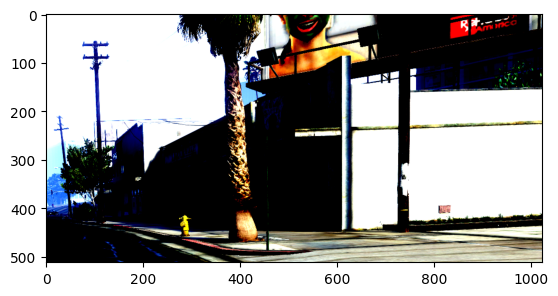

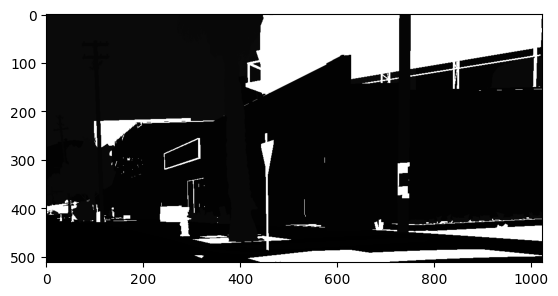

In [ ]:
# to visualize the GTA5 dataset
print(len(GTA5_train_dataset))

img, label = GTA5_train_dataset[40] # loading random image and label from the dataset
plt.imshow(img.permute(1,2,0),cmap='gray') # the permute function is to change the order of the, puts the channel as last dimension 
# dimensions of the tensor so that it is compatible with the expected format in matplotlib
plt.show()
plt.imshow(label, cmap='gray')
plt.show()

In [ ]:
# training with GTA dataset
save_path = "./save/GTA5_client.pth"

torch.cuda.empty_cache()
GTA_net = model.BiSeNetV2(n_classes)
GTA_net.to(device)


config["FDA"] = False
wandb.init(project = "GTA_training", config = config)

client_GTA = Client(f"{wandb.run.name}-client_GTA", GTA5_train_dataset, GTA_net, batch_size, device, num_epochs, hyperparam, n_classes)
client_GTA.train(num_epochs, hyperparam, save_path)
wandb.finish()

wandb: Currently logged in as: ahrit95 (was_pak). Use `wandb login --relogin` to force relogin


ID: sparkling-dust-4-client_GTA - Training...


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Step 0, Loss 3.382378339767456, Mean IoU accuracy 0.02110926353283123.
Step 50, Loss 1.5844435691833496, Mean IoU accuracy 0.1035516617023737.
Step 100, Loss 2.009798765182495, Mean IoU accuracy 0.07868300994110936.
Using "run_epoch" function from Client class



Epoch:   4%|▍         | 1/25 [01:27<34:49, 87.06s/it]

Step 0, Loss 1.8761792182922363, Mean IoU accuracy 0.09857449250911661.
Step 50, Loss 1.551547884941101, Mean IoU accuracy 0.09350812715191943.
Step 100, Loss 1.1310185194015503, Mean IoU accuracy 0.10432955496978767.
Using "run_epoch" function from Client class



Epoch:   8%|▊         | 2/25 [02:50<32:32, 84.90s/it]

Step 0, Loss 0.9155457615852356, Mean IoU accuracy 0.1532962089513375.
Step 50, Loss 1.145322561264038, Mean IoU accuracy 0.1307287250356035.
Step 100, Loss 1.0960034132003784, Mean IoU accuracy 0.14100883722970278.
Using "run_epoch" function from Client class



Epoch:  12%|█▏        | 3/25 [04:14<30:58, 84.46s/it]

Step 0, Loss 1.3117177486419678, Mean IoU accuracy 0.07973338649722601.
Step 50, Loss 1.3531789779663086, Mean IoU accuracy 0.11194682149527264.
Step 100, Loss 1.2848020792007446, Mean IoU accuracy 0.11387054211746156.
Using "run_epoch" function from Client class



Epoch:  16%|█▌        | 4/25 [05:37<29:22, 83.93s/it]

Step 0, Loss 1.588943600654602, Mean IoU accuracy 0.11657316137515446.
Step 50, Loss 1.479184627532959, Mean IoU accuracy 0.15315722317322655.
Step 100, Loss 1.9530645608901978, Mean IoU accuracy 0.10494384928839522.
Using "run_epoch" function from Client class



Epoch:  20%|██        | 5/25 [06:58<27:40, 83.04s/it]

Step 0, Loss 1.0412062406539917, Mean IoU accuracy 0.18287448898182668.
Step 50, Loss 1.0674980878829956, Mean IoU accuracy 0.13069122431424762.
Step 100, Loss 1.0299098491668701, Mean IoU accuracy 0.16971972314707343.


Epoch:  24%|██▍       | 6/25 [08:21<26:13, 82.80s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.9632076025009155, Mean IoU accuracy 0.12870344962987185.
Step 50, Loss 1.1148077249526978, Mean IoU accuracy 0.1360229922383531.
Step 100, Loss 0.7435452342033386, Mean IoU accuracy 0.18458178160584604.
Using "run_epoch" function from Client class



Epoch:  28%|██▊       | 7/25 [09:43<24:46, 82.59s/it]

Step 0, Loss 1.2001336812973022, Mean IoU accuracy 0.1848988858085296.
Step 50, Loss 1.0531078577041626, Mean IoU accuracy 0.13286495861671666.
Step 100, Loss 1.074077844619751, Mean IoU accuracy 0.13510403630831405.
Using "run_epoch" function from Client class



Epoch:  32%|███▏      | 8/25 [11:05<23:20, 82.36s/it]

Step 0, Loss 0.7507002949714661, Mean IoU accuracy 0.18902963682646884.
Step 50, Loss 0.7794500589370728, Mean IoU accuracy 0.21655985049419346.
Step 100, Loss 1.0842803716659546, Mean IoU accuracy 0.08781159327623766.


Epoch:  36%|███▌      | 9/25 [12:27<21:55, 82.20s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.0401194095611572, Mean IoU accuracy 0.1833591457242084.
Step 50, Loss 0.6897870898246765, Mean IoU accuracy 0.2011223068785453.
Step 100, Loss 0.7175391912460327, Mean IoU accuracy 0.22913783000529872.
Using "run_epoch" function from Client class



Epoch:  40%|████      | 10/25 [13:49<20:32, 82.14s/it]

Step 0, Loss 1.1442339420318604, Mean IoU accuracy 0.09361364637147532.
Step 50, Loss 1.0579502582550049, Mean IoU accuracy 0.222102382929471.
Step 100, Loss 0.7099950909614563, Mean IoU accuracy 0.17457392413574602.
Using "run_epoch" function from Client class



Epoch:  44%|████▍     | 11/25 [15:10<19:07, 81.98s/it]

Step 0, Loss 0.886821448802948, Mean IoU accuracy 0.2548374457726365.
Step 50, Loss 0.6853614449501038, Mean IoU accuracy 0.2883199140870814.
Step 100, Loss 0.9925108551979065, Mean IoU accuracy 0.18220438811842302.


Epoch:  48%|████▊     | 12/25 [16:32<17:43, 81.78s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.2440751791000366, Mean IoU accuracy 0.21110377384319937.
Step 50, Loss 1.0013850927352905, Mean IoU accuracy 0.19607168144030895.
Step 100, Loss 0.8353439569473267, Mean IoU accuracy 0.26831652378197507.


Epoch:  52%|█████▏    | 13/25 [17:53<16:19, 81.64s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.1043766736984253, Mean IoU accuracy 0.12046506579667321.
Step 50, Loss 1.1874371767044067, Mean IoU accuracy 0.13182481884788178.
Step 100, Loss 0.685160219669342, Mean IoU accuracy 0.24694409383291852.
Using "run_epoch" function from Client class



Epoch:  56%|█████▌    | 14/25 [19:14<14:56, 81.48s/it]

Step 0, Loss 0.7864822149276733, Mean IoU accuracy 0.21907270812037924.
Step 50, Loss 0.7790243625640869, Mean IoU accuracy 0.23865709867339685.
Step 100, Loss 0.5531275272369385, Mean IoU accuracy 0.2431073063474424.
Using "run_epoch" function from Client class



Epoch:  60%|██████    | 15/25 [20:35<13:33, 81.31s/it]

Step 0, Loss 0.9639812111854553, Mean IoU accuracy 0.19844699104002034.
Step 50, Loss 0.6130908131599426, Mean IoU accuracy 0.24626237056361683.
Step 100, Loss 1.0866200923919678, Mean IoU accuracy 0.19060261451671767.


Epoch:  64%|██████▍   | 16/25 [21:56<12:11, 81.25s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5718632936477661, Mean IoU accuracy 0.18331930143177286.
Step 50, Loss 0.8460981845855713, Mean IoU accuracy 0.23019282518228837.
Step 100, Loss 0.9167842864990234, Mean IoU accuracy 0.16406791766039203.
Using "run_epoch" function from Client class



Epoch:  68%|██████▊   | 17/25 [23:17<10:49, 81.16s/it]

Step 0, Loss 1.1080840826034546, Mean IoU accuracy 0.21409035087858974.
Step 50, Loss 0.7310604453086853, Mean IoU accuracy 0.19480935057334192.
Step 100, Loss 0.8669592142105103, Mean IoU accuracy 0.21401612672254966.


Epoch:  72%|███████▏  | 18/25 [24:38<09:27, 81.04s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.7253544926643372, Mean IoU accuracy 0.2200745295517633.
Step 50, Loss 0.9560864567756653, Mean IoU accuracy 0.22229937712884468.
Step 100, Loss 1.236979365348816, Mean IoU accuracy 0.2041844110081882.
Using "run_epoch" function from Client class



Epoch:  76%|███████▌  | 19/25 [25:59<08:05, 80.94s/it]

Step 0, Loss 1.0190415382385254, Mean IoU accuracy 0.17850782010511007.
Step 50, Loss 1.3033901453018188, Mean IoU accuracy 0.20430478714812694.
Step 100, Loss 0.6450133323669434, Mean IoU accuracy 0.24715636610057556.
Using "run_epoch" function from Client class



Epoch:  80%|████████  | 20/25 [27:19<06:44, 80.91s/it]

Step 0, Loss 0.9565932154655457, Mean IoU accuracy 0.13846241962318956.
Step 50, Loss 1.0316287279129028, Mean IoU accuracy 0.13146603348258137.
Step 100, Loss 0.5502763390541077, Mean IoU accuracy 0.27793874974786137.
Using "run_epoch" function from Client class



Epoch:  84%|████████▍ | 21/25 [28:40<05:23, 80.85s/it]

Step 0, Loss 0.6269156336784363, Mean IoU accuracy 0.22297379519680507.
Step 50, Loss 0.9645170569419861, Mean IoU accuracy 0.18032643465711165.
Step 100, Loss 0.7592101097106934, Mean IoU accuracy 0.21403653291480493.
Using "run_epoch" function from Client class



Epoch:  88%|████████▊ | 22/25 [30:01<04:02, 80.82s/it]

Step 0, Loss 1.1546554565429688, Mean IoU accuracy 0.18804213436169695.
Step 50, Loss 1.0241236686706543, Mean IoU accuracy 0.19887228597712225.
Step 100, Loss 0.7331394553184509, Mean IoU accuracy 0.2802826550148947.
Using "run_epoch" function from Client class



Epoch:  92%|█████████▏| 23/25 [31:21<02:41, 80.75s/it]

Step 0, Loss 0.5712255835533142, Mean IoU accuracy 0.2906026688661166.
Step 50, Loss 0.9059630036354065, Mean IoU accuracy 0.22564288904887347.
Step 100, Loss 1.5392996072769165, Mean IoU accuracy 0.15409095649745508.
Using "run_epoch" function from Client class



Epoch:  96%|█████████▌| 24/25 [32:42<01:20, 80.77s/it]

Step 0, Loss 0.6371639370918274, Mean IoU accuracy 0.2640895911675906.
Step 50, Loss 0.6247732043266296, Mean IoU accuracy 0.24242112974283406.
Step 100, Loss 0.6112593412399292, Mean IoU accuracy 0.25670349152708355.
Using "run_epoch" function from Client class



Epoch: 100%|██████████| 25/25 [34:03<00:00, 81.74s/it]


Loss,███▄▃▇▃▅▄▃▆▃▄▃▂▃▃▆▃▄▂▅▁▃▅▁▅▂▅▂▂▂▂▃▃▅▄▂▁▁
Mean IoU accuracy,▁▃▃▄▂▃▄▃▄▄▄▆▆▅▆▄▆▃▄▄▆▆█▇▄▇▅▇▅▇▅▅▆▇▅▅▅▆▇▇
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,0.82182
Mean IoU accuracy,0.22665
epoch,24


Loaded model: save/GTA5_client.pth.


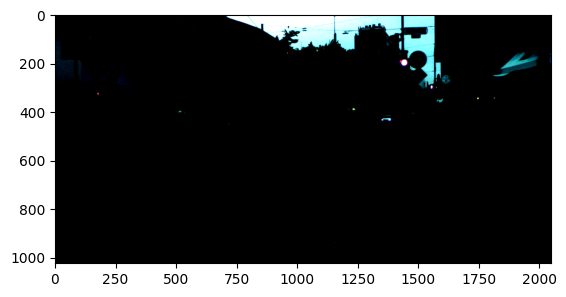

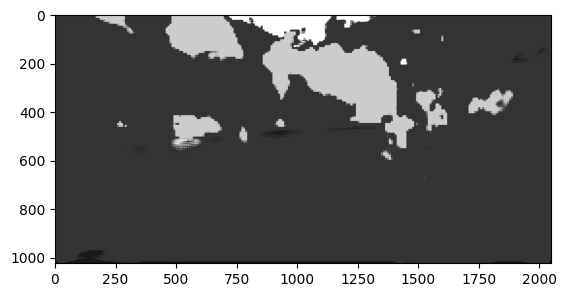

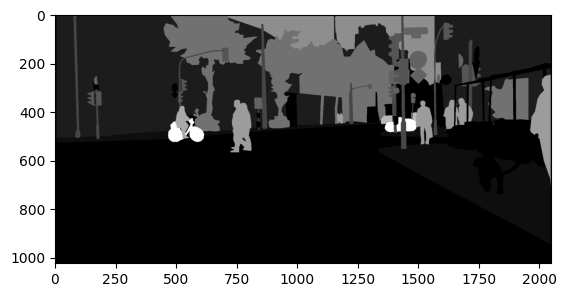

Accuracy: 0.09114932234084304


In [ ]:
#test with Cityscape dataset on both A and B partitions
load_path = "save/GTA5_client.pth"

torch.cuda.empty_cache()
test_GTA5_net = model.BiSeNetV2(n_classes)
test_GTA5_net.to(device)

test_GTA5 = Client(f"test_GTA5",test_dataset_A, test_GTA5_net, batch_size, device, num_epochs, hyperparam, n_classes, server=True)
test_GTA5.load_model(load_path)

mIoU_accuracy = test_GTA5.test()
print(f"Accuracy: {mIoU_accuracy}")

# FDA and domain adaptation 

This section deals with the implementation of style transfer technique using FDA algorithm to answer the problem of domain shift between cityscape and gta5 dataset.

The new directory inside the GTA5 folder is created for each partition(A/B) and split(unifrom/hetero). Each imgae of the GTA5 is modified based on the style of different images from cityscape dataset and is stored inside the new folder which are then used for further training.  

In [ ]:
# run this section only once for the creation of 4 different directories based on partitions(A/B) and split(uniform/heterogenous) 

torch.cuda.empty_cache()
net_fedavg = model.BiSeNetV2(n_classes)
net_fedavg.to(device)

#creating the list of clients for both partitions A and B and both splits(uniform/hetero)
clients = []
for i, cl in enumerate(uniform_split_AI):  
  client_dataset = Cityscapes(img_dir,mask_dir, uniform_split_AI[i], transform=None, cl19 = True)  #create dataset for client i
  client = Client(f"c{cl}", client_dataset, net_fedavg, batch_size_fedavg, device, epochs_fedavg, hyperparam_fedavg, autosave=False)  #create the object Client for each client on the list with its own dataset
  clients.append(client)


# creating bank of styles as per [11]

bank_of_styles = []
sum_amp = 0
number_img = 0
for client in clients:
  for img, label in client.dataset:
    src_img = img
    #get amplitude of frequencies cropped to the center
    amp_src = FDA.get_amplitude(src_img, L=0.01) #input - image from tuple (image, label), L = square to crop center of amplitude signal
    sum_amp += amp_src
    number_img += 1

  avg_amp = sum_amp/number_img
  bank_of_styles.append(avg_amp)

GTA5_train_txt = './data/GTA5/train.txt'
GTA5_img_dir = './data/GTA5/images'
GTA5_mask_dir = './data/GTA5/labels'

os.mkdir("./data/GTA5/FDA_split_A_I")

directory = "./data/GTA5/FDA_split_A_I" 
GTA5_FDA = []
GTA5_dataset = GTA5(GTA5_img_dir,GTA5_mask_dir,GTA5_train_txt,transform=None, cl19=True)

# New GTA5 dataset with domain adaptation - save new images in a folder
img_list=[]
for i in range(len(GTA5_dataset)):
  img, label = GTA5_dataset[i]

  img = FDA.apply_style(img, bank_of_styles, L=0.01)
  img = np.abs(img.transpose((1,2,0)))
  im = Image.fromarray(np.uint8(img))

  img_list.append(img)

  path = os.path.join(directory, GTA5_dataset.images[i])

  im.save(path,"png")




In [ ]:
# run this section for data visualization 
# the actual image 
index = 8

path = os.path.join(GTA5_img_dir, GTA5_train_dataset.images[index])
im = Image.open(path)
im.show()

# the corresponding image with style transfer
plt.imshow(img_list[index].astype('uint8')) 

#NOTE: this setion would not run if the previous section is not executed before this because of img_list not present..


In [ ]:
#training with new GTA dataset obtained after the style transfer 

save_path = "./save/client_GTA5_FDA_split_B_II.pth" 
new_data_dir = "./data/GTA5/FDA_split_B_II/"

torch.cuda.empty_cache()
GTA5_net = model.BiSeNetV2(n_classes)
GTA5_net.to(device)
GTA5_dataset_FDA = GTA5(new_data_dir,GTA5_mask_dir,GTA5_train_txt,transform=train_transform, cl19=True)

config["FDA"] = True
wandb.init(project = "GTA_training", config = config)

client_GTA = Client(f"{wandb.run.name}-client_GTA", GTA5_dataset_FDA, GTA5_net, batch_size, device, num_epochs, hyperparam, n_classes)
client_GTA.train(num_epochs, hyperparam, save_path)
wandb.finish()

ID: celestial-serenity-8-client_GTA - Training...


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Step 0, Loss 3.318673610687256, Mean IoU accuracy 0.019349826327904888.
Step 50, Loss 1.4677200317382812, Mean IoU accuracy 0.06025700860861887.
Step 100, Loss 1.5461246967315674, Mean IoU accuracy 0.09982344995793518.
Using "run_epoch" function from Client class



Epoch:   4%|▍         | 1/25 [08:22<3:20:56, 502.37s/it]

Step 0, Loss 1.643091082572937, Mean IoU accuracy 0.0668563717961693.
Step 50, Loss 1.862394094467163, Mean IoU accuracy 0.06838966327980717.
Step 100, Loss 2.147946357727051, Mean IoU accuracy 0.09250828726417945.


Epoch:   8%|▊         | 2/25 [09:40<1:36:55, 252.85s/it]

Using "run_epoch" function from Client class

Step 0, Loss 1.5153024196624756, Mean IoU accuracy 0.12721214643460482.
Step 50, Loss 1.8238073587417603, Mean IoU accuracy 0.09394118295541.
Step 100, Loss 1.2771919965744019, Mean IoU accuracy 0.11823889283938667.
Using "run_epoch" function from Client class



Epoch:  12%|█▏        | 3/25 [10:59<1:03:36, 173.49s/it]

Step 0, Loss 1.162611484527588, Mean IoU accuracy 0.14907655771817416.
Step 50, Loss 1.4605568647384644, Mean IoU accuracy 0.13801544114700262.
Step 100, Loss 1.1111637353897095, Mean IoU accuracy 0.1711465608195874.
Using "run_epoch" function from Client class



Epoch:  16%|█▌        | 4/25 [12:17<47:33, 135.90s/it]  

Step 0, Loss 0.7115889191627502, Mean IoU accuracy 0.18055801150227013.
Step 50, Loss 1.0457162857055664, Mean IoU accuracy 0.08847179994491285.
Step 100, Loss 1.4244163036346436, Mean IoU accuracy 0.11909352435148805.
Using "run_epoch" function from Client class



Epoch:  20%|██        | 5/25 [13:35<38:19, 114.99s/it]

Step 0, Loss 0.9141079783439636, Mean IoU accuracy 0.19022722286686825.
Step 50, Loss 1.2278497219085693, Mean IoU accuracy 0.16621989846136814.
Step 100, Loss 1.1625717878341675, Mean IoU accuracy 0.16132936631121392.
Using "run_epoch" function from Client class



Epoch:  24%|██▍       | 6/25 [14:55<32:37, 103.00s/it]

Step 0, Loss 0.7960689067840576, Mean IoU accuracy 0.17041515459473397.
Step 50, Loss 1.109227180480957, Mean IoU accuracy 0.15423828324071295.
Step 100, Loss 1.112684965133667, Mean IoU accuracy 0.08727061618595297.


Epoch:  28%|██▊       | 7/25 [16:14<28:31, 95.07s/it] 

Using "run_epoch" function from Client class

Step 0, Loss 1.5280015468597412, Mean IoU accuracy 0.12938744572016705.
Step 50, Loss 0.7912420630455017, Mean IoU accuracy 0.17453118081086738.
Step 100, Loss 1.4816033840179443, Mean IoU accuracy 0.2046007014804425.
Using "run_epoch" function from Client class



Epoch:  32%|███▏      | 8/25 [17:37<25:51, 91.24s/it]

Step 0, Loss 0.7401235699653625, Mean IoU accuracy 0.2041029150294781.
Step 50, Loss 0.8386374115943909, Mean IoU accuracy 0.2704725575104488.
Step 100, Loss 0.8371618986129761, Mean IoU accuracy 0.2243559920058349.
Using "run_epoch" function from Client class



Epoch:  36%|███▌      | 9/25 [19:04<23:59, 89.96s/it]

Step 0, Loss 0.6535242199897766, Mean IoU accuracy 0.1956238338043863.
Step 50, Loss 0.8053080439567566, Mean IoU accuracy 0.2136323649114274.
Step 100, Loss 0.9962444305419922, Mean IoU accuracy 0.1942024230639997.
Using "run_epoch" function from Client class



Epoch:  40%|████      | 10/25 [20:28<22:01, 88.07s/it]

Step 0, Loss 0.7153664827346802, Mean IoU accuracy 0.19566122083254742.
Step 50, Loss 0.9852828979492188, Mean IoU accuracy 0.16198628492376657.
Step 100, Loss 0.7216158509254456, Mean IoU accuracy 0.23520546328069042.
Using "run_epoch" function from Client class



Epoch:  44%|████▍     | 11/25 [21:51<20:11, 86.51s/it]

Step 0, Loss 0.7006301879882812, Mean IoU accuracy 0.1804411577601199.
Step 50, Loss 0.977609395980835, Mean IoU accuracy 0.1762559209929034.
Step 100, Loss 1.053647756576538, Mean IoU accuracy 0.16739436984794942.
Using "run_epoch" function from Client class



Epoch:  48%|████▊     | 12/25 [23:11<18:20, 84.68s/it]

Step 0, Loss 0.576982319355011, Mean IoU accuracy 0.26773309768318826.
Step 50, Loss 1.5659723281860352, Mean IoU accuracy 0.16301398707007406.
Step 100, Loss 1.2285284996032715, Mean IoU accuracy 0.18538424481659152.
Using "run_epoch" function from Client class



Epoch:  52%|█████▏    | 13/25 [24:30<16:34, 82.89s/it]

Step 0, Loss 1.2884851694107056, Mean IoU accuracy 0.2362103266089515.
Step 50, Loss 0.7446736097335815, Mean IoU accuracy 0.23711358349391706.
Step 100, Loss 1.0623046159744263, Mean IoU accuracy 0.16053180105470283.
Using "run_epoch" function from Client class



Epoch:  56%|█████▌    | 14/25 [25:50<15:01, 81.93s/it]

Step 0, Loss 1.0422039031982422, Mean IoU accuracy 0.24037317341185413.
Step 50, Loss 0.8620965480804443, Mean IoU accuracy 0.18157777780010417.
Step 100, Loss 0.8609611392021179, Mean IoU accuracy 0.22373769339411406.
Using "run_epoch" function from Client class



Epoch:  60%|██████    | 15/25 [27:09<13:32, 81.20s/it]

Step 0, Loss 0.9071805477142334, Mean IoU accuracy 0.18221348935271822.
Step 50, Loss 0.6944388151168823, Mean IoU accuracy 0.2958787240533629.
Step 100, Loss 0.7685041427612305, Mean IoU accuracy 0.18203717131843683.
Using "run_epoch" function from Client class



Epoch:  64%|██████▍   | 16/25 [28:28<12:05, 80.57s/it]

Step 0, Loss 0.5544018149375916, Mean IoU accuracy 0.1936506617961069.
Step 50, Loss 1.1760116815567017, Mean IoU accuracy 0.19543644726586268.
Step 100, Loss 0.6063660383224487, Mean IoU accuracy 0.2387288442553828.
Using "run_epoch" function from Client class



Epoch:  68%|██████▊   | 17/25 [29:47<10:38, 79.86s/it]

Step 0, Loss 0.9948780536651611, Mean IoU accuracy 0.1765575656394146.
Step 50, Loss 1.0496312379837036, Mean IoU accuracy 0.18184406201226364.
Step 100, Loss 0.5782576203346252, Mean IoU accuracy 0.23417902665969742.
Using "run_epoch" function from Client class



Epoch:  72%|███████▏  | 18/25 [31:06<09:17, 79.64s/it]

Step 0, Loss 0.9237325191497803, Mean IoU accuracy 0.17855078812329095.
Step 50, Loss 0.9407987594604492, Mean IoU accuracy 0.15405219229500444.
Step 100, Loss 0.7681179046630859, Mean IoU accuracy 0.20989047750574144.
Using "run_epoch" function from Client class



Epoch:  76%|███████▌  | 19/25 [32:23<07:53, 78.91s/it]

Step 0, Loss 0.7809601426124573, Mean IoU accuracy 0.17034263678185976.
Step 50, Loss 0.6060168147087097, Mean IoU accuracy 0.23947229643427562.
Step 100, Loss 0.8158366680145264, Mean IoU accuracy 0.1983076996916645.
Using "run_epoch" function from Client class



Epoch:  80%|████████  | 20/25 [33:41<06:32, 78.54s/it]

Step 0, Loss 0.9421254992485046, Mean IoU accuracy 0.21256193958190994.
Step 50, Loss 0.6534477472305298, Mean IoU accuracy 0.2618685841328501.
Step 100, Loss 0.6002476215362549, Mean IoU accuracy 0.26743810668766627.
Using "run_epoch" function from Client class



Epoch:  84%|████████▍ | 21/25 [34:59<05:13, 78.41s/it]

Step 0, Loss 0.5733013153076172, Mean IoU accuracy 0.24528849293040939.
Step 50, Loss 0.67691570520401, Mean IoU accuracy 0.31992381936868597.
Step 100, Loss 1.0923389196395874, Mean IoU accuracy 0.24419894581764265.
Using "run_epoch" function from Client class



Epoch:  88%|████████▊ | 22/25 [36:17<03:55, 78.40s/it]

Step 0, Loss 1.488867163658142, Mean IoU accuracy 0.17113438017535706.
Step 50, Loss 0.4631088078022003, Mean IoU accuracy 0.2557627025129791.
Step 100, Loss 0.7203522324562073, Mean IoU accuracy 0.21905730195321851.
Using "run_epoch" function from Client class



Epoch:  92%|█████████▏| 23/25 [37:35<02:36, 78.19s/it]

Step 0, Loss 1.083168864250183, Mean IoU accuracy 0.19015167178702697.
Step 50, Loss 1.0463056564331055, Mean IoU accuracy 0.15649732124439172.
Step 100, Loss 0.9820110201835632, Mean IoU accuracy 0.17790910004446053.


Epoch:  96%|█████████▌| 24/25 [38:53<01:18, 78.31s/it]

Using "run_epoch" function from Client class

Step 0, Loss 0.8420045375823975, Mean IoU accuracy 0.23691130990817538.
Step 50, Loss 0.9113712310791016, Mean IoU accuracy 0.21196985600907797.
Step 100, Loss 0.8405694961547852, Mean IoU accuracy 0.21362579779390653.
Using "run_epoch" function from Client class



Epoch: 100%|██████████| 25/25 [40:12<00:00, 96.51s/it]


Loss,█▅▃▅▇▇▄▃▃▃▄▄▃▁▃▂▂▁▃▄▂▃▄▄▂▂▃▃▂▃▁▂▃▄▃▂▂▄▂▁
Mean IoU accuracy,▁▂▄▃▃▄▄▅▇▅▄▅▅▇▄▇▇▆▅▅█▇▆▆▇▇▆▅▆▇█▆▇▅▄▇█▆▆█
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,0.93043
Mean IoU accuracy,0.11311
epoch,24


Loaded model: save/client_GTA5_FDA_split_B_II.pth.


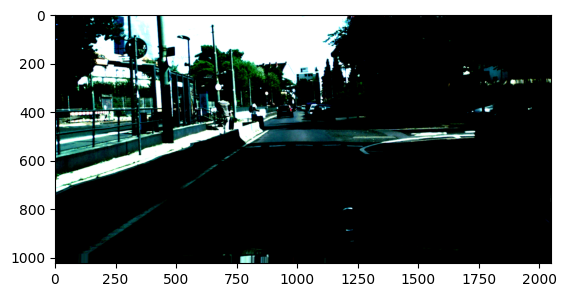

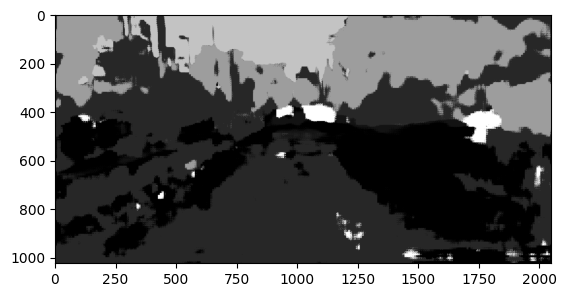

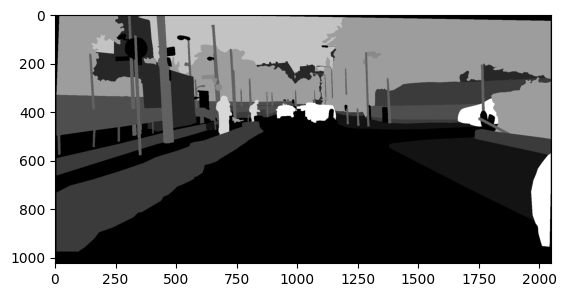

Accuracy: 0.11583811226579852


In [ ]:
# testing with Cityscape dataset

load_path = "save/client_GTA5_FDA_split_B_II.pth"  
valid_dataset_A = Cityscapes(img_dir,mask_dir, test_data_A, transform=test_transform, cl19 = True)
valid_dataset_B = Cityscapes(img_dir,mask_dir, test_data_B, transform=test_transform, cl19 = True)

torch.cuda.empty_cache()
test_GTA5_net = model.BiSeNetV2(n_classes)
test_GTA5_net.to(device)

test_GTA5 = Client(f"test_GTA5",valid_dataset_B, test_GTA5_net, batch_size, device, num_epochs, hyperparam, n_classes, server=True)
test_GTA5.load_model(load_path)

mIoU_accuracy = test_GTA5.test()
print(f"Accuracy: {mIoU_accuracy}")


# Step 5: Federated self training using pseudo labels

This section deals with the implementation of FedAvg training on cityscapes dataset using pseudo labels as ground truth. 

The pseudo labels are generated by the teacher model which are then used by the student model as ground truth labels. The cross entropy loss function is used to calculate the loss. 

Three stratigies to update the studen model are used as per the project requirement. 

In [23]:
# creaing varibale to save server
ST_save_server_path = "./save/ST_server_B_I.pth"

T_list = [0, 1, 3]

# training using best saved checkpoint from 4.2 or 4.4
load_path = "save/GTA5_client.pth" # input the saved model from 4.2 or 4.4

for i in range(len(T_list)): 

    T = T_list[i]

    # creatin the teacher and student models
    torch.cuda.empty_cache()
    teacher_model = model.BiSeNetV2(n_classes).to(device)
    student_model = model.BiSeNetV2(n_classes).to(device)

    # creating clients list for the self-training task
    clients = []
    for cl in range(len(uniform_split_BI)):
      client_dataset = Cityscapes(img_dir,mask_dir, uniform_split_BI[cl], transform=train_transform, cl19 = True)
      client = Student(f'client_ST{cl}',client_dataset, student_model,batch_size_fedavg, device, epochs_fedavg, hyperparam_fedavg, n_classes,teacher=teacher_model,autosave=False)

      client.load_teacher(load_path)
      client.load_model(load_path)

      clients.append(client)

    wandb_config_fedavg["dataset"] = f"ST split_A_I_t={i}"
    wandb.init(project = "FedAvg_Self_Training", config = wandb_config_fedavg)
    ST_server = Server(f"{wandb.run.name}_serverBI", teacher_model, device, clients, hyperparam=hyperparam_fedavg, number_classes=n_classes, epochs_per_client=epochs_fedavg, isstudent=True)
    ST_server.load_model(load_path)
    ST_server.training_fedAvg(clients, rounds=number_rounds, t=T, path_server_model=ST_save_server_path)
    wandb.finish()

RuntimeError: ignored